# AquaGrade Mask R-CNN Model
> Since the collective members of the group, agreed upon, that a single bounding boxes will not do for our task, ever since the overhaul of their Computer Vision (CV) technique, they changed to masks segmentation or CV enthusiasts says **instance segmentation**.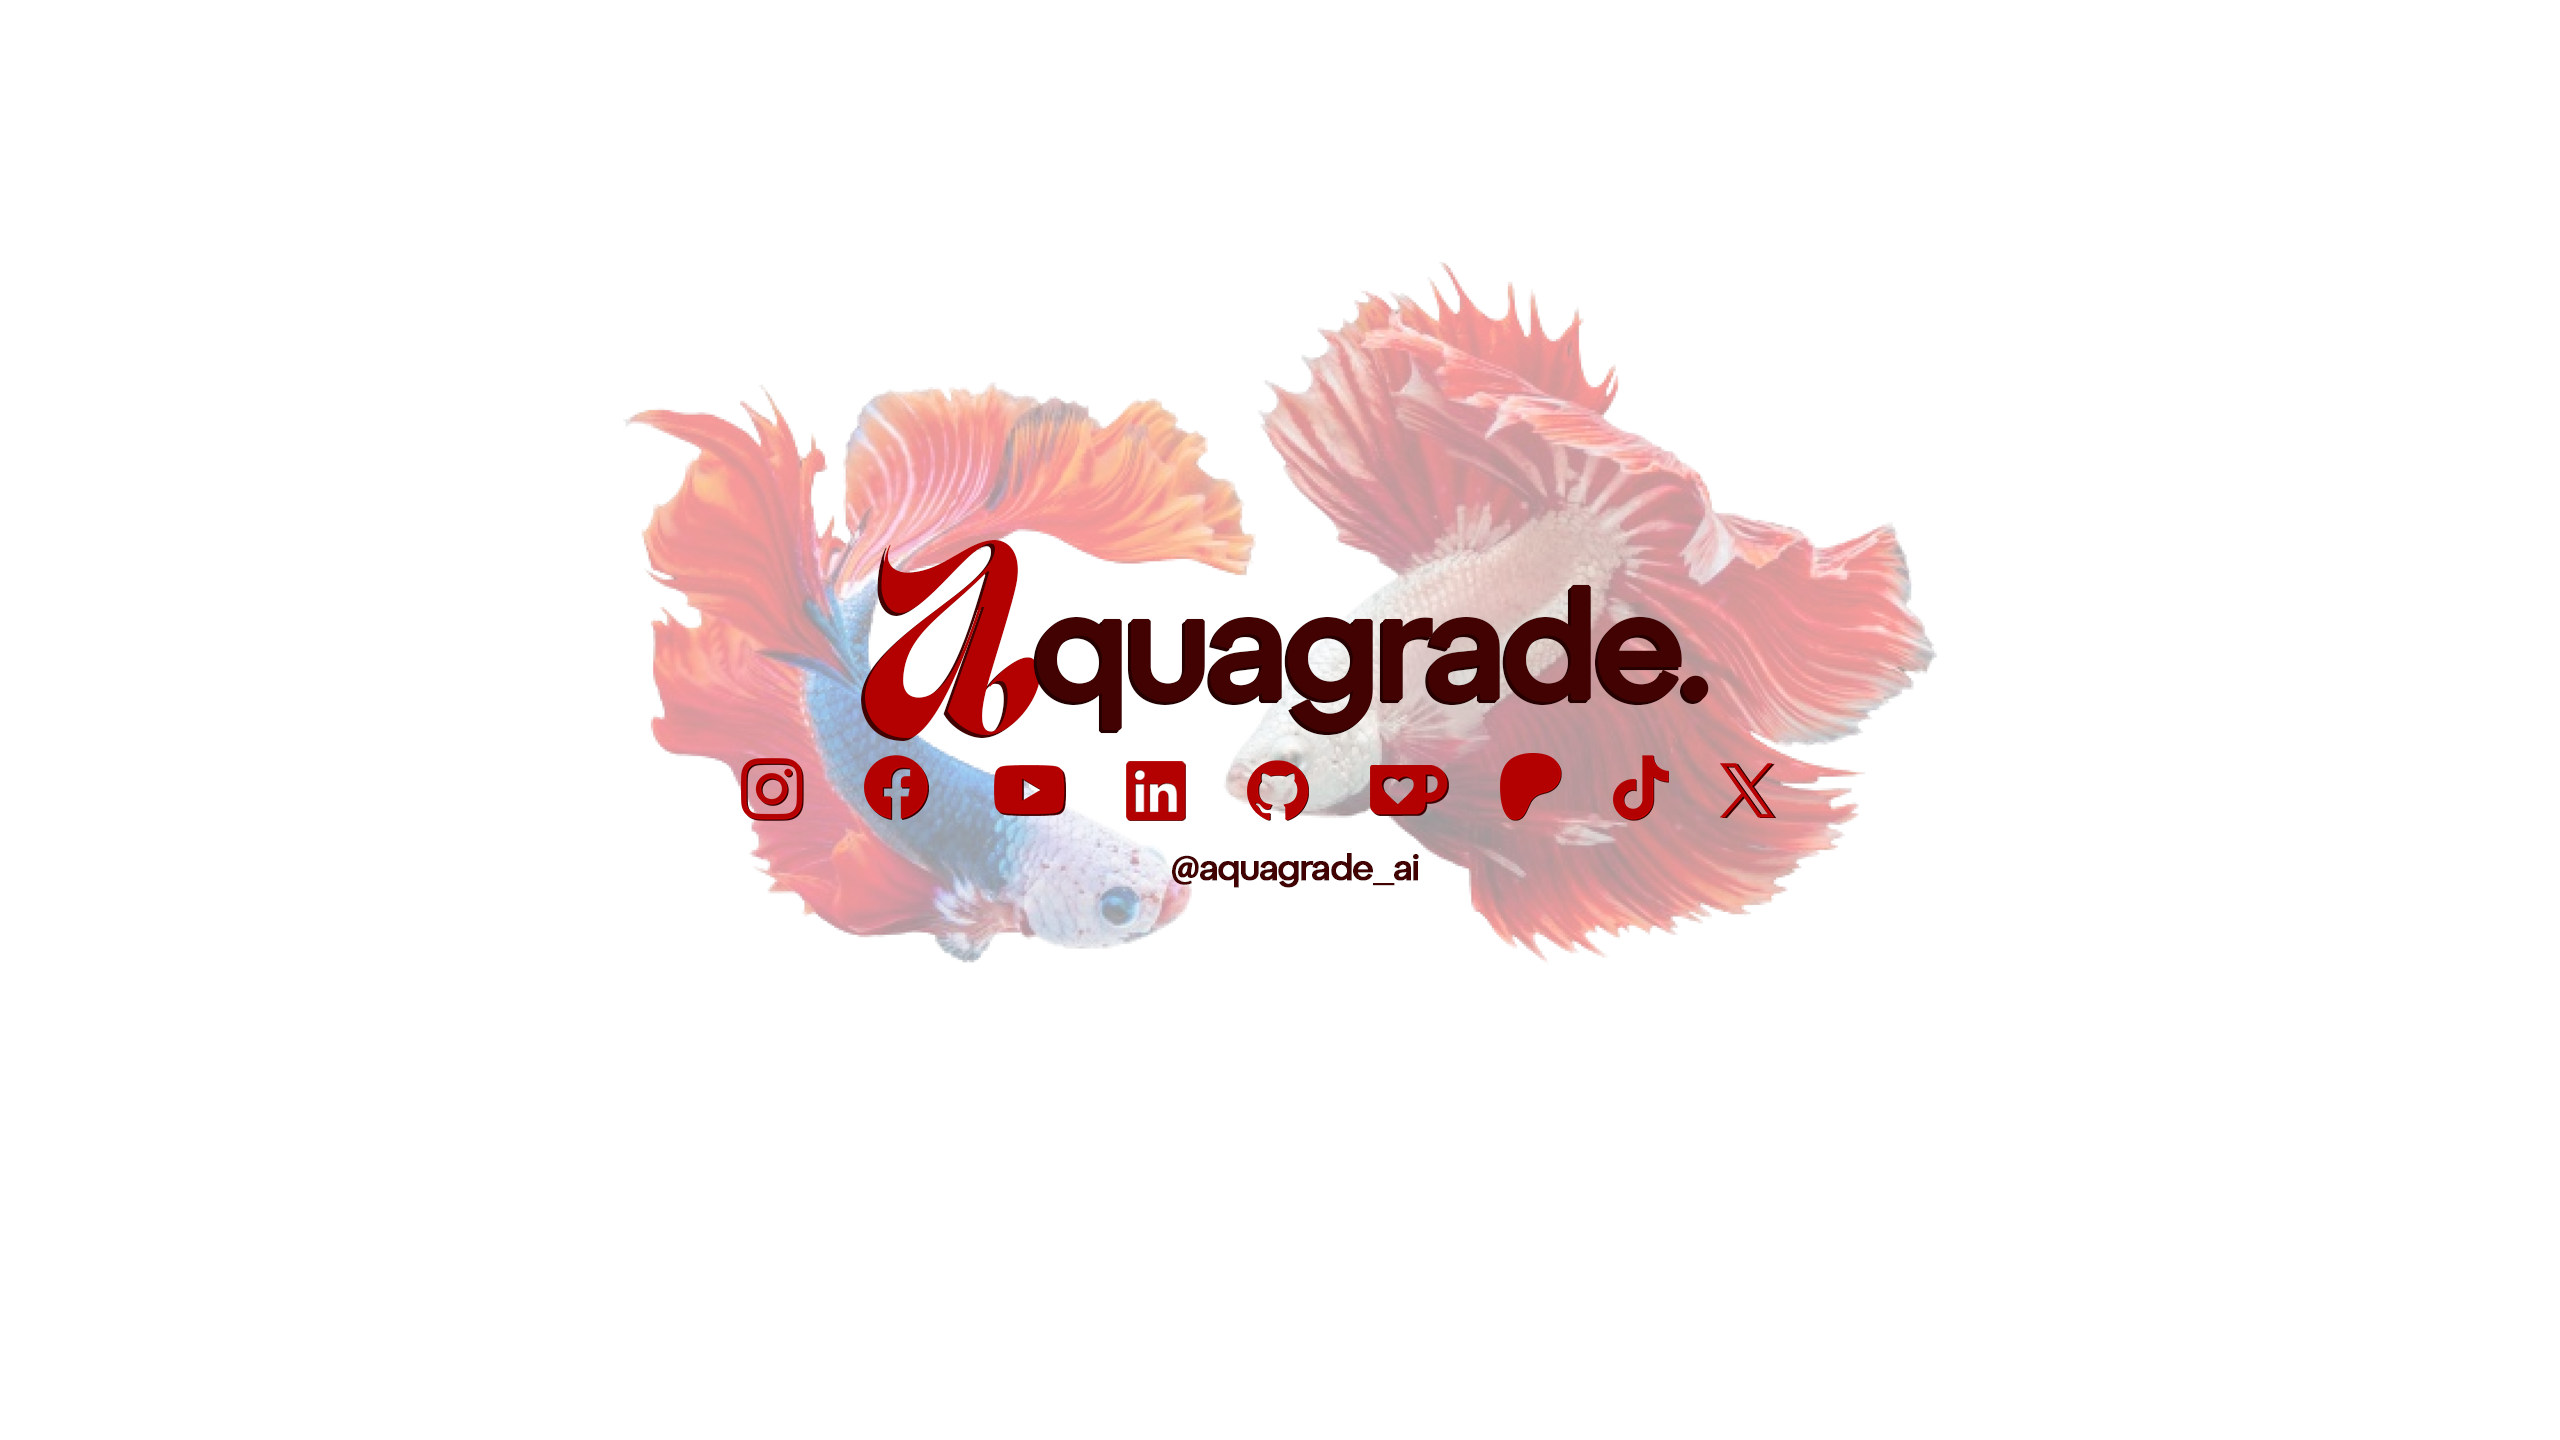

## Setups
> Includes, **paths necessary** for *proper working of directories*, **installing libraries** out of the box, and then **importing the libraries** that have been installed.

### Necessary Paths
> All necessary routes are *initialized* here for **better organization of paths**

In [24]:
# * Load the absolute folder of the current directory in Colab
COLAB_DIR = os.path.abspath(os.getcwd())

# * Define paths correctly without the leading '/' in the relative path
PROJECT_PATH = os.path.join(COLAB_DIR, 'drive', 'MyDrive', 'colab_nb', 'aquagrade_pkg')

# * Load config path
CONFIG_PATH = os.path.join(PROJECT_PATH, 'config')

# * Load data path
DATASET_PATH = os.path.join(PROJECT_PATH, 'dataset')

# * Joins aquagrade_pkg/src
SRC_PATH = os.path.join(PROJECT_PATH, 'src')

# * Load the requirements.txt path
REQUIREMENTS_PATH = os.path.join(PROJECT_PATH, 'requirements.txt')

# * `models` folder root
MODELS_PATH = os.path.join(PROJECT_PATH, 'models')

# * Set the default pretrained models location
PRETRAINED_MODELS_PATH = os.path.join(MODELS_PATH, 'pretrained')


### Installation of Dependencies/Libraries
> All **dependencies** are **installed via single configuration** file named, `requirements.txt`

In [19]:
# Install the requirements
!pip install -r {REQUIREMENTS_PATH}

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 890.6/890.6 kB 11.9 MB/s eta 0:00:00


### Imports
> _**all of the imports** from useful **external and internal libraries** of Python is here_ **Imports:**
1.   `os`
2.   `json`



  

In [20]:
from google.colab import drive
drive.mount('/content/drive/')

# * Import general libraries

# * For pathfinding or navigating the file system
import os
import json
import math
from pathlib import Path
import random
import hashlib
import shutil
from tkinter import *

# * Import necessary libraries for image processing
import numpy as np
from PIL import Image, ImageDraw
from PIL import ImageOps

# * Imports for plotting
import matplotlib.pyplot as plt
import pandas as pd

from pycocotools.coco import COCO
import matplotlib.patches as patches

# * Imports for GUI libraries
from tqdm import tqdm

import wandb

# * Import necessary libraries for model training
import torch
import torchmetrics
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch import nn, optim
import torchvision.models as models
import torchvision.transforms.functional as F
from torch.optim.lr_scheduler import ReduceLROnPlateau

# * Import sci-kit cross-validation libraries
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, precision_recall_curve, ConfusionMatrixDisplay

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


## Preprocessing Data Pipeline
> This is one of the crucial pipeline, as it handles **the preparation of dataset**, that includes, of course;

1.   Loading and Verification of Dataset Content & Paths,
2.   Data Normalization,
3.   Data Cleaning,
4.   Data Augmentation,
5.   Loading and Verification of Dataset Images & True Labels.

### Loading Data from JSON Formatted File
> *this is a modular function made for the purpose of **reading a json file**, useful for later deeds*

In [ ]:
def load_json(json_path):
    """Load data from a COCO-format JSON file."""
    with open(json_path, "r") as f:
        return json.load(f)

### Verification of Train, Valid & Test Path and Label Path
> *this aims to **verify** if the **dataset routes** and **label routes** is **well-routed** within the JSON file config data*

In [ ]:
# Read dataset_paths.json

DATASET_CONFIG_FILE = os.path.join(CONFIG_PATH, 'dataset_routes.json')
ANNOTATION_CONFIG_FILE = os.path.join(CONFIG_PATH, 'annotation_routes.json')

dataset_paths = load_json(DATASET_CONFIG_FILE)
annotation_paths = load_json(ANNOTATION_CONFIG_FILE)

# * Dataset and Instances of Labels
TRAIN_IMAGES_PATH = dataset_paths['train']
VALID_IMAGES_PATH = dataset_paths['valid']
TEST_IMAGES_PATH = dataset_paths['test']

TRAIN_LABEL_PATH = annotation_paths['instances_train']
VALID_LABEL_PATH = annotation_paths['instances_valid']

# Verify paths within the subset of dataset
print(f"Verification of dataset routes/paths:".upper())
print(f"Train path exists: {os.path.exists(TRAIN_IMAGES_PATH)}")
print(f"Validation path exists: {os.path.exists(VALID_IMAGES_PATH)}")
print(f"Test path exists: {os.path.exists(TEST_IMAGES_PATH)}")

# Print full paths for reference
print("\nspecified Full paths inside json file :".upper())
print(f"Train: {os.path.abspath(dataset_paths['train'])}")
print(f"Validation: {os.path.abspath(dataset_paths['valid'])}")
print(f"Test: {os.path.abspath(dataset_paths['test'])}")

print("\nVerification of label routes/paths:".upper())
print(f"Train labels path exists: {os.path.exists(TRAIN_LABEL_PATH)}")
print(f"Validation labels path exists: {os.path.exists(VALID_LABEL_PATH)}")

# Print full paths for reference
print("\nspecified Full paths inside json file :".upper())
print(f"Train: {os.path.abspath(annotation_paths['instances_train'])}")
print(f"Validation: {os.path.abspath(annotation_paths['instances_valid'])}")

VERIFICATION OF DATASET ROUTES/PATHS:
Train path exists: True
Validation path exists: True
Test path exists: True

SPECIFIED FULL PATHS INSIDE JSON FILE :
Train: /content/drive/MyDrive/colab_nb/aquagrade_pkg/dataset/train
Validation: /content/drive/MyDrive/colab_nb/aquagrade_pkg/dataset/valid
Test: /content/drive/MyDrive/colab_nb/aquagrade_pkg/dataset/test

VERIFICATION OF LABEL ROUTES/PATHS:
Train labels path exists: True
Validation labels path exists: True

SPECIFIED FULL PATHS INSIDE JSON FILE :
Train: /content/drive/MyDrive/colab_nb/aquagrade_pkg/dataset/annotations/instances_train.json
Validation: /content/drive/MyDrive/colab_nb/aquagrade_pkg/dataset/annotations/instances_valid.json


### Visualization of Splitted Dataset
> The code below will **show the distribution of images to 70:10:10** ratio of **train, valid, and test raw images**

In [ ]:
# Function to load and resize images
def load_and_resize_image(image_path, target_size=(100, 100)):
    try:
        with Image.open(image_path) as img:
            return img.resize(target_size, Image.LANCZOS)
    except Exception as e:
        print(f"Error loading image {image_path}: {str(e)}")
        return Image.new('RGB', target_size, color='red')

# Function to create image grid
def create_image_grid(images_path, grid_size):
    image_files = [f for f in os.listdir(images_path) if f.lower().endswith(
        ('.png', '.jpg', '.jpeg', '.bmp', '.gif'))]
    grid = np.zeros((grid_size * 100, grid_size * 100, 3), dtype=np.uint8)
    for i, img_file in enumerate(tqdm(image_files[:grid_size*grid_size], desc="Loading images")):
        if i >= grid_size * grid_size:
            break
        row = i // grid_size
        col = i % grid_size
        img_path = os.path.join(images_path, img_file)
        img = load_and_resize_image(img_path)
        grid[row*100:(row+1)*100, col*100:(col+1)*100] = np.array(img)
    return grid, len(image_files)

    # Calculate grid size for all sets
train_grid_size = min(100, math.ceil(
    math.sqrt(len(os.listdir(TRAIN_IMAGES_PATH)))))
valid_grid_size = min(100, math.ceil(
    math.sqrt(len(os.listdir(VALID_IMAGES_PATH)))))
test_grid_size = min(100, math.ceil(
    math.sqrt(len(os.listdir(TEST_IMAGES_PATH)))))

# Create grids
train_grid, train_total = create_image_grid(TRAIN_IMAGES_PATH, train_grid_size)
val_grid, val_total = create_image_grid(VALID_IMAGES_PATH, valid_grid_size)
test_grid, test_total = create_image_grid(TEST_IMAGES_PATH, test_grid_size)

# Display the grids
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(60, 20))

ax1.imshow(train_grid)
ax1.axis('off')
ax1.set_title(f"Training Dataset Images ({train_grid_size}x{train_grid_size} grid)")

ax2.imshow(val_grid)
ax2.axis('off')
ax2.set_title(f"Validation Dataset Images ({valid_grid_size}x{valid_grid_size} grid)")

ax3.imshow(test_grid)
ax3.axis('off')
ax3.set_title(f"Test Dataset Images ({test_grid_size}x{test_grid_size} grid)")

# * Plot the grids graphically
plt.tight_layout()
plt.show()

print(f"Total training images displayed: {min(train_grid_size*train_grid_size, train_total)}")
print(f"Total training images in dataset: {train_total}")
print(f"Total validation images displayed: {min(valid_grid_size*valid_grid_size, val_total)}")
print(f"Total validation images in dataset: {val_total}")
print(f"Total test images displayed: {min(test_grid_size*test_grid_size, test_total)}")
print(f"Total test images in dataset: {test_total}")

Output hidden; open in https://colab.research.google.com to view.

### Check Total Class Names

In [ ]:
import json

# Function to load JSON data and extract class information
def get_class_info(json_path):
    with open(json_path, 'r') as f:
        data = json.load(f)

    # Extract class names from the 'categories' section
    class_names = [category['name'] for category in data['categories']]

    # Count the number of unique classes
    num_classes = len(class_names)

    return num_classes, class_names

# Get class info for training and validation
train_num_classes, train_class_names = get_class_info(TRAIN_LABEL_PATH)
valid_num_classes, valid_class_names = get_class_info(VALID_LABEL_PATH)

# Print results for both sets
print("Training Set:")
print("Number of classes:", train_num_classes)
print("Class names:", train_class_names)
print("\nValidation Set:")
print("Number of classes:", valid_num_classes)
print("Class names:", valid_class_names)


Training Set:
Number of classes: 36
Class names: ['Bangus-EYE-CLARITY -0-', 'Bangus-EYE-CLARITY -1-', 'Bangus-EYE-SHAPE -0-', 'Bangus-EYE-SHAPE -1-', 'Bangus-EYE-SHAPE -2-', 'Bangus-GILL-COVER -0-', 'Bangus-GILL-COVER -1-', 'Bangus-GILL-COVER -2-', 'Bangus-GILL-COVER -3-', 'Bangus-SKIN -0-', 'Bangus-SKIN -1-', 'Bangus-SKIN -2-', 'Galunggong-EYE-CLARITY -0-', 'Galunggong-EYE-CLARITY -1-', 'Galunggong-EYE-SHAPE -0-', 'Galunggong-EYE-SHAPE -1-', 'Galunggong-EYE-SHAPE -2-', 'Galunggong-GILL-COVER -0-', 'Galunggong-GILL-COVER -1-', 'Galunggong-GILL-COVER -2-', 'Galunggong-GILL-COVER -3-', 'Galunggong-SKIN -0-', 'Galunggong-SKIN -1-', 'Galunggong-SKIN -2-', 'Tilapia-EYE-CLARITY -0-', 'Tilapia-EYE-CLARITY -1-', 'Tilapia-EYE-SHAPE -0-', 'Tilapia-EYE-SHAPE -1-', 'Tilapia-EYE-SHAPE -2-', 'Tilapia-GILL-COVER -0-', 'Tilapia-GILL-COVER -1-', 'Tilapia-GILL-COVER -2-', 'Tilapia-GILL-COVER -3-', 'Tilapia-SKIN -0-', 'Tilapia-SKIN -1-', 'Tilapia-SKIN -2-']

Validation Set:
Number of classes: 36
Class na

### Image Resizing with Aspect Ratio Padding

In [ ]:
import os
from PIL import Image


def resize_and_save_images(input_dir, output_dir, target_size=640):
    """
    Resize images to a square size of 640x640 with padding while maintaining the aspect ratio.
    Save the resized images in the specified output directory.

    Parameters:
        input_dir (str): Path to the directory containing original images.
        output_dir (str): Path to the directory where resized images will be saved.
        target_size (int): The target size for both width and height of the output images (default is 640x640).
    """
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    for filename in os.listdir(input_dir):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
            image_path = os.path.join(input_dir, filename)
            image = Image.open(image_path)
            original_width, original_height = image.size

            # Check if the image is already 640x640
            if original_width == target_size and original_height == target_size:
                print(
                    f"{filename} is already {target_size}x{target_size}. Copying to output directory.")
                image.save(os.path.join(output_dir, filename))
                continue

            # Determine new dimensions and padding
            if original_width > original_height:
                new_width = target_size
                new_height = int(
                    target_size * original_height / original_width)
                padding_x = 0
                padding_y = (target_size - new_height) // 2
            else:
                new_height = target_size
                new_width = int(target_size * original_width / original_height)
                padding_x = (target_size - new_width) // 2
                padding_y = 0

            # Resize and pad the image
            resized_image = image.resize(
                (new_width, new_height), Image.LANCZOS)
            new_image = Image.new("RGB", (target_size, target_size))
            new_image.paste(resized_image, (padding_x, padding_y))

            # Save the padded, resized image to the output directory
            output_path = os.path.join(output_dir, filename)
            new_image.save(output_path)
            print(f"Resized and saved {filename} to {output_dir}")

# Example usage:
input_directory = f"{DATASET_PATH}/archives/orig/train"
output_directory = f"{DATASET_PATH}/train/train-640"
resize_and_save_images(input_directory, output_directory)

1-1-_jpeg.rf.57758fad284e56e6583a80bc94ff56de.jpg is already 640x640. Copying to output directory.
1-1-_png.rf.c8c69cd5ff881fd1e60ac535a63465e7.jpg is already 640x640. Copying to output directory.
1-10-_png.rf.5b36d6b71904e892e54de0085f21b565.jpg is already 640x640. Copying to output directory.
1-1-_png.rf.13b650b21d94cf6f34ee1a961cbb175b.jpg is already 640x640. Copying to output directory.
1-13-_png.rf.fefd6e1d6bd260ab2b2261b493f4aa00.jpg is already 640x640. Copying to output directory.
1-14-_png.rf.b82b1279ca0c70350a720bc37face7e2.jpg is already 640x640. Copying to output directory.
1-13-_png.rf.000ec0ccd7caa0de0527e082f2fd05e7.jpg is already 640x640. Copying to output directory.
1-15-_png.rf.113fb432957f12da1b4f678c07e46361.jpg is already 640x640. Copying to output directory.
1-18-_png.rf.eb09c6deb390131dc693b92be950409a.jpg is already 640x640. Copying to output directory.
1-19-_png.rf.aefeae8736d0f79d98a4e96cd450b05c.jpg is already 640x640. Copying to output directory.
1-17-_png.rf

This ones a bit different, it searches for the any galunggong within the created dataset that is downsided to 640x640

In [ ]:
import os
from PIL import Image

def resize_and_save_images(input_dir, output_dir, target_size=640, prefix="IMG_20240726"):
    """
    Resize images with a specific prefix to a square size of 640x640 with padding while maintaining the aspect ratio.
    Save the resized images in the specified output directory.

    Parameters:
        input_dir (str): Path to the directory containing original images.
        output_dir (str): Path to the directory where resized images will be saved.
        target_size (int): The target size for both width and height of the output images (default is 640x640).
        prefix (str): Prefix to filter images for processing (default is "IMG_20240726").
    """
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    for filename in os.listdir(input_dir):
        # Process only images with the specified prefix
        if filename.startswith(prefix) and filename.lower().endswith(('.png', '.jpg', '.jpeg')):
            image_path = os.path.join(input_dir, filename)
            image = Image.open(image_path)
            original_width, original_height = image.size

            # Check if the image is already 640x640
            if original_width == target_size and original_height == target_size:
                print(
                    f"{filename} is already {target_size}x{target_size}. Copying to output directory.")
                image.save(os.path.join(output_dir, filename))
                continue

            # Determine new dimensions and padding
            if original_width > original_height:
                new_width = target_size
                new_height = int(target_size * original_height / original_width)
                padding_x = 0
                padding_y = (target_size - new_height) // 2
            else:
                new_height = target_size
                new_width = int(target_size * original_width / original_height)
                padding_x = (target_size - new_width) // 2
                padding_y = 0

            # Resize and pad the image
            resized_image = image.resize((new_width, new_height), Image.LANCZOS)
            new_image = Image.new("RGB", (target_size, target_size))
            new_image.paste(resized_image, (padding_x, padding_y))

            # Save the padded, resized image to the output directory
            output_path = os.path.join(output_dir, filename)
            new_image.save(output_path)
            print(f"Resized and saved {filename} to {output_dir}")

# Example usage:
input_directory = f"{DATASET_PATH}/test-640/"
output_directory = f"{DATASET_PATH}/test-gal/"
resize_and_save_images(input_directory, output_directory)


IMG_20240726_165851.jpg is already 640x640. Copying to output directory.
IMG_20240726_165720.jpg is already 640x640. Copying to output directory.
IMG_20240726_153800.jpg is already 640x640. Copying to output directory.
IMG_20240726_154155.jpg is already 640x640. Copying to output directory.
IMG_20240726_185002_713.jpg is already 640x640. Copying to output directory.
IMG_20240726_184952_483.jpg is already 640x640. Copying to output directory.
IMG_20240726_184957_225.jpg is already 640x640. Copying to output directory.
IMG_20240726_185002_706.jpg is already 640x640. Copying to output directory.
IMG_20240726_184952_848.jpg is already 640x640. Copying to output directory.
IMG_20240726_184948_785.jpg is already 640x640. Copying to output directory.
IMG_20240726_120556_188.jpg is already 640x640. Copying to output directory.
IMG_20240726_120556_044.jpg is already 640x640. Copying to output directory.
IMG_20240726_120616_527.jpg is already 640x640. Copying to output directory.
IMG_20240726_12

### Verification of Each Dataset's Image Dimension

In [ ]:
import os
from PIL import Image

# Cleaned dataset directory
CLEANED_DATASET_SUPERSET = DATASET_PATH

# Define paths for each dataset subset
dataset_root = CLEANED_DATASET_SUPERSET
subsets = ["train", "valid", "test"]
target_width, target_height = 640, 640  # Target dimensions

def verify_image_dimensions(subset_path):
    correct_count = 0
    incorrect_count = 0
    total_images = 0
    incorrect_images = []

    print(f"Checking images in subset path: {subset_path}")

    for root, _, files in os.walk(subset_path):
        for file_name in files:
            if file_name.endswith(('.jpg', '.jpeg', '.png')):
                total_images += 1
                image_path = os.path.join(root, file_name)

                # Debug print to confirm image paths and check if they exist
                print(f"Processing file: {image_path}")

                if os.path.exists(image_path):
                    with Image.open(image_path) as img:
                        width, height = img.size
                        print(f"Image dimensions for {file_name}: {width}x{height}")  # Debug line

                        if width == target_width and height == target_height:
                            correct_count += 1
                        else:
                            incorrect_count += 1
                            incorrect_images.append((file_name, width, height))
                else:
                    print(f"Warning: File {image_path} does not exist.")

    return correct_count, incorrect_count, total_images, incorrect_images

# Dictionary to store results for each subset
results = {}

print("DIMENSION VERIFICATION RESULTS:")
# Verify each subset and store results
for subset in subsets:
    subset_path = os.path.join(dataset_root, subset)  # Modify to match your folder structure
    correct_count, incorrect_count, total_images, incorrect_images = verify_image_dimensions(subset_path)
    results[subset] = {
        "correct_count": correct_count,
        "incorrect_count": incorrect_count,
        "total_images": total_images,
        "incorrect_images": incorrect_images
    }

# Print summary for all subsets
for subset, data in results.items():
    print(f"\nSummary for '{subset}' subset:")
    print(f" - Total images scanned: {data['total_images']}")
    print(f" - Correct dimensions ({target_width}x{target_height}): {data['correct_count']}")
    print(f" - Images with incorrect dimensions: {data['incorrect_count']}")

    if data['incorrect_count'] == 0:
        print(f" - All images have correct dimensions!\n {subset.upper()} DIMENSION SIZE CHECKS : PASSED")
    else:
        print(f"{subset.upper()} DIMENSION SIZE CHECKS : FAILED")

    if data['incorrect_count'] > 0:
        print(" - Images with incorrect dimensions:")
        for file_name, width, height in data['incorrect_images']:
            print(f"   - {file_name}: {width}x{height}")


DIMENSION VERIFICATION RESULTS:
Checking images in subset path: /content/drive/MyDrive/colab_nb/aquagrade_pkg/dataset/train
Processing file: /content/drive/MyDrive/colab_nb/aquagrade_pkg/dataset/train/1-1-_jpeg.rf.57758fad284e56e6583a80bc94ff56de.jpg
Image dimensions for 1-1-_jpeg.rf.57758fad284e56e6583a80bc94ff56de.jpg: 640x640
Processing file: /content/drive/MyDrive/colab_nb/aquagrade_pkg/dataset/train/1-10-_png.rf.5b36d6b71904e892e54de0085f21b565.jpg
Image dimensions for 1-10-_png.rf.5b36d6b71904e892e54de0085f21b565.jpg: 640x640
Processing file: /content/drive/MyDrive/colab_nb/aquagrade_pkg/dataset/train/1-1-_png.rf.13b650b21d94cf6f34ee1a961cbb175b.jpg
Image dimensions for 1-1-_png.rf.13b650b21d94cf6f34ee1a961cbb175b.jpg: 640x640
Processing file: /content/drive/MyDrive/colab_nb/aquagrade_pkg/dataset/train/1-1-_png.rf.c8c69cd5ff881fd1e60ac535a63465e7.jpg
Image dimensions for 1-1-_png.rf.c8c69cd5ff881fd1e60ac535a63465e7.jpg: 640x640
Processing file: /content/drive/MyDrive/colab_nb/aqu

### Data Cleaning + Visualization & Verification

In [ ]:
import os
import hashlib
from PIL import Image, ImageOps
import numpy as np
import math
import matplotlib.pyplot as plt
from tqdm import tqdm

def hash_image(image_path):
    """Generate a hash for an image to detect duplicates."""
    with open(image_path, "rb") as f:
        img_hash = hashlib.md5(f.read()).hexdigest()
    return img_hash

def get_unique_filename(clean_dir, img_name, original_img_name):
    """Generate a unique filename if a file with the same name exists in the clean_dir."""
    base_name, ext = os.path.splitext(img_name)
    counter = 1
    new_name = img_name
    while os.path.exists(os.path.join(clean_dir, new_name)):
        new_name = f"{base_name}_{counter}{ext}"
        counter += 1

    # Notify the user when renaming occurs due to same filename but different hash
    if new_name != original_img_name:
        print(f"Renaming image '{original_img_name}' to '{new_name}' due to the same filename but different content.")

    return new_name

def clear_directory(directory):
    """Remove all files from the specified directory."""
    for filename in os.listdir(directory):
        file_path = os.path.join(directory, filename)
        if os.path.isfile(file_path):
            os.remove(file_path)

def clean_data(image_dir, clean_dir, allowed_formats=('jpeg', 'png', 'jpg'), target_size=(224, 224), resize_size=(256, 256)):
    """
    Clean image dataset by performing the following:
    1. Removing invalid or corrupted files.
    2. Removing unsupported image formats.
    3. Checking for duplicate images.
    4. Saving cleaned images to a new folder with unique file names.
    """
    if not os.path.exists(clean_dir):
        os.makedirs(clean_dir)
    else:
        # Clear existing files in the clean_dir
        clear_directory(clean_dir)

    unique_hashes = set()  # To track unique images
    duplicate_count = 0
    invalid_images = 0
    unsupported_formats = 0

    if(image_dir == TRAIN_IMAGES_PATH):
        dataset_type = "Training"
    elif(image_dir == VALID_IMAGES_PATH):
        dataset_type = "Validation"
    elif(image_dir == TEST_IMAGES_PATH):
        dataset_type = "Test"

    for img_name in os.listdir(image_dir):
        img_path = os.path.join(image_dir, img_name)
        try:
            # Open the image to check if it's valid
            with Image.open(img_path) as img:
                img.verify()  # Check if the image is valid (not corrupted)
                img = Image.open(img_path)  # Reopen for further checks after verification

                # Check if the image format is allowed
                if img.format.lower() not in allowed_formats:
                    print(f"Skipping {img_name}: Unsupported format")
                    unsupported_formats += 1
                    continue

                # Resize image to a larger size (e.g., 256x256) while preserving aspect ratio
                img = ImageOps.fit(img, resize_size, method=Image.LANCZOS)  # Resize to 256x256

                # Crop or pad the image to the target size (224x224)
                img = ImageOps.fit(img, target_size, method=Image.LANCZOS, centering=(0.5, 0.5))

                # Generate a hash to identify duplicates
                img_hash = hash_image(img_path)
                if img_hash in unique_hashes:
                    print(f"Skipping {img_name}: Duplicate image")
                    duplicate_count += 1
                    continue

                unique_hashes.add(img_hash)

                # Generate a unique filename to avoid overwriting
                unique_img_name = get_unique_filename(clean_dir, img_name, img_name)

                    # Create the directory if it doesn't exist
                os.makedirs(os.path.dirname(clean_dir), exist_ok=True)

                # Save resized and padded image to the clean_dir
                img.save(os.path.join(clean_dir, unique_img_name))

        except (IOError, SyntaxError) as e:
            print(f"Skipping {img_name}: Error loading image")
            invalid_images += 1

    print(f"\n{dataset_type} Cleaned Images saved at {clean_dir}")
    print(f"{dataset_type} Data Cleaning Summary: \n - Duplicates: {duplicate_count} \n - Invalid Images: {invalid_images} \n"
          f" - Unsupported Formats: {unsupported_formats}\n\n Total Cleaned {dataset_type} Images: {len(os.listdir(clean_dir))}\n")

# Cleaning all datasets
clean_data(TRAIN_IMAGES_PATH, CLEANED_TRAIN_IMAGES_PATH, target_size=(224, 224), resize_size=(224, 224))
clean_data(VALID_IMAGES_PATH, CLEANED_VALID_IMAGES_PATH, target_size=(224, 224), resize_size=(224, 224))
clean_data(TEST_IMAGES_PATH, CLEANED_TEST_IMAGES_PATH, target_size=(224, 224), resize_size=(224, 224))

# Helper function to load and resize images for display in grids
def load_and_resize_image(image_path, target_size=(100, 100)):
    try:
        with Image.open(image_path) as img:
            return img.resize(target_size, Image.LANCZOS)
    except Exception as e:
        print(f"Error loading image {image_path}: {str(e)}")
        return Image.new('RGB', target_size, color='red')

# Function to create image grid
def create_image_grid(images_path, grid_size):
    image_files = [f for f in os.listdir(images_path) if f.lower().endswith(
        ('.png', '.jpg', '.jpeg', '.bmp', '.gif'))]
    grid = np.zeros((grid_size * 100, grid_size * 100, 3), dtype=np.uint8)
    for i, img_file in enumerate(tqdm(image_files[:grid_size*grid_size], desc="Loading images")):
        if i >= grid_size * grid_size:
            break
        row = i // grid_size
        col = i % grid_size
        img_path = os.path.join(images_path, img_file)
        img = load_and_resize_image(img_path)
        grid[row*100:(row+1)*100, col*100:(col+1)*100] = np.array(img)
    return grid, len(image_files)

# Calculate grid sizes for displaying the images
train_grid_size = min(100, math.ceil(math.sqrt(len(os.listdir(CLEANED_TRAIN_IMAGES_PATH)))))
valid_grid_size = min(100, math.ceil(math.sqrt(len(os.listdir(CLEANED_VALID_IMAGES_PATH)))))
test_grid_size = min(100, math.ceil(math.sqrt(len(os.listdir(CLEANED_TEST_IMAGES_PATH)))))

# Generate image grids for each dataset
train_grid, train_total = create_image_grid(CLEANED_TRAIN_IMAGES_PATH, train_grid_size)
valid_grid, valid_total = create_image_grid(CLEANED_VALID_IMAGES_PATH, valid_grid_size)
test_grid, test_total = create_image_grid(CLEANED_TEST_IMAGES_PATH, test_grid_size)

# Plot the three grids side-by-side
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(60, 20))

ax1.imshow(train_grid)
ax1.axis('off')
ax1.set_title(f"Cleaned Training Images ({train_grid_size}x{train_grid_size} grid)")

ax2.imshow(valid_grid)
ax2.axis('off')
ax2.set_title(f"Cleaned Validation Images ({valid_grid_size}x{valid_grid_size} grid)")

ax3.imshow(test_grid)
ax3.axis('off')
ax3.set_title(f"Cleaned Test Images ({test_grid_size}x{test_grid_size} grid)")

# Display the layout
plt.tight_layout()
plt.show()

# Print summaries
print(f"\nTrain Images Display In Grid: {min(train_grid_size * train_grid_size, train_total)} / {train_total}")
print(f"Valid Images Display In Grid: {min(valid_grid_size * valid_grid_size, valid_total)} / {valid_total}")
print(f"Test Images Display In Grid: {min(test_grid_size * test_grid_size, test_total)} / {test_total}")

### Removal of Leading Hashed Prefix on `file_name` JSON Object

In [77]:
import json
import re

def load_json(file_path):
    """Load JSON data from a file."""
    with open(file_path, 'r') as f:
        return json.load(f)

def save_json(data, file_path):
    """Save JSON data to a file."""
    with open(file_path, 'w') as f:
        json.dump(data, f, indent=4)
    print(f"Data saved to '{file_path}'")

def clean_file_names(data, key="images", file_key="file_name", pattern=r"^images\\[a-f0-9]+-"):
    """Clean file names in JSON data by removing specified patterns."""
    for item in data.get(key, []):
        item[file_key] = re.sub(pattern, "", item[file_key])

def main(input_path, output_path):
    """Main function to clean file names in a JSON file."""
    data = load_json(input_path)
    clean_file_names(data)
    save_json(data, output_path)

# Run the script
input_file = os.path.join(DATASET_PATH, "annotations", "merged_coco_train.json")
output_file = os.path.join(DATASET_PATH, "annotations", "removed_prefix_train.json")
main(input_file, output_file)

Data saved to '/content/drive/MyDrive/colab_nb/aquagrade_pkg/dataset/annotations/removed_prefix_train.json'


#### 人には必ずを手番がある。

In [4]:
import json
import re
import os

def load_json(file_path):
    """Load JSON data from a file."""
    with open(file_path, 'r') as f:
        return json.load(f)

def save_json(data, file_path):
    """Save JSON data to a file."""
    with open(file_path, 'w') as f:
        json.dump(data, f, indent=4)
    print(f"Data saved to '{file_path}'")

def clean_file_names(data, key="images", file_key="file_name", pattern=r"^images\\[a-f0-9]+-"):
    """Clean file names in JSON data by removing specified patterns."""
    for item in data.get(key, []):
        item[file_key] = re.sub(pattern, "", item[file_key])

def remove_category_by_name(data, target_string="GILL-COLOR"):
    """Remove categories containing a specific string in their name and update annotations."""
    categories = data.get("categories", [])
    annotations = data.get("annotations", [])

    # Identify categories to remove
    categories_to_remove = [cat['id'] for cat in categories if target_string in cat['name']]
    data['categories'] = [cat for cat in categories if cat['id'] not in categories_to_remove]

    # Update annotations to remove any references to removed categories
    data['annotations'] = [ann for ann in annotations if ann['category_id'] not in categories_to_remove]

    # Re-map category IDs to ensure continuous indices starting from 0
    id_mapping = {cat['id']: i for i, cat in enumerate(data['categories'])}
    for cat in data['categories']:
        cat['id'] = id_mapping[cat['id']]
    for ann in data['annotations']:
        if ann['category_id'] in id_mapping:
            ann['category_id'] = id_mapping[ann['category_id']]

def main(input_path, output_path):
    """Main function to clean file names and remove specific categories in a JSON file."""
    data = load_json(input_path)
    clean_file_names(data)
    remove_category_by_name(data)
    save_json(data, output_path)

# Run the script
input_file = os.path.join(DATASET_PATH, "annotations", "merged_coco_train.json")
output_file = os.path.join(DATASET_PATH, "annotations", "removed_prefix_train.json")
main(input_file, output_file)

Data saved to '/content/drive/MyDrive/colab_nb/aquagrade_pkg/dataset/annotations/removed_prefix_train.json'


### Scaling Down of Image Dimension and its Annotation for Standard Sizing

In [ ]:
import json

def scale_coco_annotations(input_json_path, output_json_path, target_width=640, target_height=640):
    # Load the COCO JSON file
    with open(input_json_path, 'r') as f:
        data = json.load(f)

    # Define scaling factors based on original and target sizes
    for image in data['images']:
        original_width = image['width']
        original_height = image['height']
        x_scale = target_width / original_width
        y_scale = target_height / original_height

        # Update image dimensions
        image['width'] = target_width
        image['height'] = target_height

        # Update annotations for this image
        for annotation in data['annotations']:
            if annotation['image_id'] == image['id']:
                # Scale each segmentation polygon
                for i, segmentation in enumerate(annotation['segmentation']):
                    scaled_polygon = [
                        coord * x_scale if idx % 2 == 0 else coord * y_scale
                        for idx, coord in enumerate(segmentation)
                    ]
                    annotation['segmentation'][i] = scaled_polygon

                # Scale bbox (x, y, width, height)
                bbox = annotation['bbox']
                bbox[0] *= x_scale  # x
                bbox[1] *= y_scale  # y
                bbox[2] *= x_scale  # width
                bbox[3] *= y_scale  # height
                annotation['bbox'] = bbox

                # Scale area (considering area scaling factor as x_scale * y_scale)
                annotation['area'] *= x_scale * y_scale

    # Save the modified data to a new JSON file
    with open(output_json_path, 'w') as f:
        json.dump(data, f)

    print("Scaling complete. Scaled annotations, bounding boxes, and areas saved to", output_json_path)

# Usage
input_json_path = os.path.join(DATASET_PATH, "annotations", f"instances_valid.json")
output_json_path = os.path.join(DATASET_PATH, "annotations", f"scaled_valid.json")
scale_coco_annotations(input_json_path, output_json_path)


Scaling complete. Scaled annotations, bounding boxes, and areas saved to /content/drive/MyDrive/colab_nb/aquagrade_pkg/dataset/annotations/scaled_valid.json


### Dataset Integrity Verification

In [5]:
import os
import json

class COCOVerifier:
    def __init__(self, image_dir, coco_json_path):
        """
        Initialize the COCOVerifier with paths to the image directory and COCO JSON file.
        """
        self.image_dir = image_dir
        self.coco_json_path = coco_json_path
        self.image_filenames = set()
        self.json_filenames = set()

    def load_data(self):
        """
        Load image filenames from the directory and JSON file.
        """
        # Load image filenames from the directory
        self.image_filenames = {f for f in os.listdir(self.image_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))}

        # Load image filenames from the JSON file
        with open(self.coco_json_path, 'r') as f:
            coco_data = json.load(f)
            self.json_filenames = {img['file_name'] for img in coco_data['images']}

    def verify(self):
        """
        Verify and print a report on the consistency between directory images and JSON entries.
        """
        # Calculate matches and mismatches
        matched_images = self.image_filenames & self.json_filenames
        missing_in_json = self.image_filenames - self.json_filenames
        missing_in_dir = self.json_filenames - self.image_filenames

        # Report
        print("COCO Verification Report")
        print("========================")
        print(f"Total images in directory: {len(self.image_filenames)}")
        print(f"Total images in JSON file: {len(self.json_filenames)}")
        print(f"Matched images: {len(matched_images)}")
        print(f"Images in directory but not in JSON: {len(missing_in_json)}")
        print(f"Images in JSON but not in directory: {len(missing_in_dir)}")

        # Optionally, list mismatches
        if missing_in_json:
            print("\nImages in directory but missing in JSON:")
            for filename in missing_in_json:
                print(f" - {filename}")

        if missing_in_dir:
            print("\nImages in JSON but missing in directory:")
            for filename in missing_in_dir:
                print(f" - {filename}")

# Usage example
if __name__ == "__main__":
    # Define paths
    image_dir = os.path.join(DATASET_PATH, "cleaned" , "train")
    coco_json_path = os.path.join(DATASET_PATH, "annotations", "removed_prefix_train.json")

    # Initialize and run verifier
    verifier = COCOVerifier(image_dir, coco_json_path)
    verifier.load_data()
    verifier.verify()


COCO Verification Report
Total images in directory: 639
Total images in JSON file: 639
Matched images: 639
Images in directory but not in JSON: 0
Images in JSON but not in directory: 0


### Annotation Cleaning

In [ ]:
import os
import json

def clean_coco_annotations(image_dir, coco_json_path, output_json_path):
    # Step 1: Get the set of image filenames in the specified directory
    image_filenames = set(os.listdir(image_dir))
    total_images_in_directory = len(image_filenames)

    # Step 2: Load the COCO annotations JSON file
    with open(coco_json_path, 'r') as f:
        coco_data = json.load(f)

    # Print out total images and annotations in the JSON file
    total_images_in_json = len(coco_data['images'])
    total_annotations_in_json = len(coco_data['annotations'])

    print(f"Total images found in directory: {total_images_in_directory}")
    print(f"Total images in JSON file: {total_images_in_json}")
    print(f"Total annotations in JSON file: {total_annotations_in_json}")

    # Step 3: Filter images based on file presence in the directory
    # Only keep images in COCO JSON that have corresponding files in the directory
    valid_image_ids = set()
    filtered_images = []
    for image_info in coco_data['images']:
        if image_info['file_name'] in image_filenames:
            filtered_images.append(image_info)
            valid_image_ids.add(image_info['id'])

    # Step 4: Filter annotations based on valid image IDs
    filtered_annotations = [ann for ann in coco_data['annotations'] if ann['image_id'] in valid_image_ids]

    # Print out the number of images and annotations retained
    print(f"Total images retained after cleaning: {len(filtered_images)}")
    print(f"Total annotations retained after cleaning: {len(filtered_annotations)}")

    # Optional Step 5: Filter categories if needed
    # (COCO format usually contains all categories even if some aren't in the annotations, so we often keep all)
    filtered_categories = coco_data['categories']

    # Step 6: Create the new COCO JSON structure
    cleaned_coco_data = {
        'images': filtered_images,
        'annotations': filtered_annotations,
        'categories': filtered_categories
    }

    # Step 7: Save the cleaned JSON data to the output file
    with open(output_json_path, 'w') as f:
        json.dump(cleaned_coco_data, f, indent=4)

    print(f"Cleaned COCO annotations saved to {output_json_path}")

# Directory with images
image_dir = os.path.join(DATASET_PATH, "valid")

# Path to the original COCO-format JSON
coco_json_path = os.path.join(DATASET_PATH, "annotations", "instances_valid.json")

# Path to save the cleaned COCO JSON
output_json_path = os.path.join(DATASET_PATH, "annotations", "cleaned_instances_valid.json")

clean_coco_annotations(image_dir, coco_json_path, output_json_path)

Total images found in directory: 80
Total images in JSON file: 80
Total annotations in JSON file: 263
Total images retained after cleaning: 77
Total annotations retained after cleaning: 251
Cleaned COCO annotations saved to /content/drive/MyDrive/colab_nb/aquagrade_pkg/dataset/annotations/cleaned_instances_valid.json


### True Labels Visualization Via Selective Search (Manual)

#### Masked-Contoured

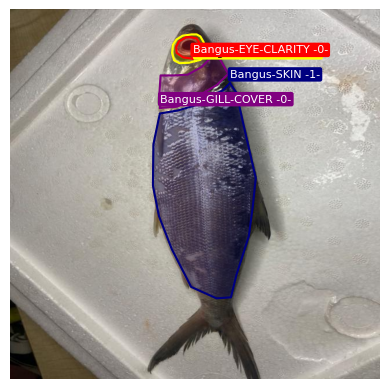

In [10]:
import json
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image, ImageDraw, ImageFont

# Helper function to normalize colors for Matplotlib
def normalize_color(color):
    return tuple([c / 255 for c in color])

# Define a color map for up to 36 categories based on category ID
CATEGORY_COLORS = {
    0: {"fill": (255, 0, 0, 128), "text_bg": (255, 0, 0), "text": (255, 255, 255)},  # Red with white text
    1: {"fill": (0, 255, 0, 128), "text_bg": (0, 255, 0), "text": (0, 0, 0)},      # Green with black text
    2: {"fill": (0, 0, 255, 128), "text_bg": (0, 0, 255), "text": (255, 255, 255)},  # Blue with white text
    3: {"fill": (255, 255, 0, 128), "text_bg": (255, 255, 0), "text": (0, 0, 0)},  # Yellow with black text
    4: {"fill": (255, 165, 0, 128), "text_bg": (255, 165, 0), "text": (0, 0, 0)},  # Orange with black text
    5: {"fill": (128, 0, 128, 128), "text_bg": (128, 0, 128), "text": (255, 255, 255)},
    6: {"fill": (0, 128, 128, 128), "text_bg": (0, 128, 128), "text": (255, 255, 255)},
    7: {"fill": (128, 128, 0, 128), "text_bg": (128, 128, 0), "text": (255, 255, 255)},
    8: {"fill": (128, 0, 0, 128), "text_bg": (128, 0, 0), "text": (255, 255, 255)},
    9: {"fill": (0, 128, 0, 128), "text_bg": (0, 128, 0), "text": (255, 255, 255)},
    10: {"fill": (0, 0, 128, 128), "text_bg": (0, 0, 128), "text": (255, 255, 255)},
    11: {"fill": (255, 255, 255, 128), "text_bg": (255, 255, 255), "text": (0, 0, 0)},
    12: {"fill": (192, 192, 192, 128), "text_bg": (192, 192, 192), "text": (0, 0, 0)},
    13: {"fill": (128, 128, 128, 128), "text_bg": (128, 128, 128), "text": (0, 0, 0)},
    14: {"fill": (255, 0, 255, 128), "text_bg": (255, 0, 255), "text": (0, 0, 0)},
    15: {"fill": (0, 255, 255, 128), "text_bg": (0, 255, 255), "text": (0, 0, 0)},
    16: {"fill": (255, 255, 128, 128), "text_bg": (255, 255, 128), "text": (0, 0, 0)},
    17: {"fill": (128, 255, 128, 128), "text_bg": (128, 255, 128), "text": (0, 0, 0)},
    18: {"fill": (128, 128, 255, 128), "text_bg": (128, 128, 255), "text": (0, 0, 0)},
    19: {"fill": (255, 128, 128, 128), "text_bg": (255, 128, 128), "text": (0, 0, 0)},
    20: {"fill": (128, 255, 255, 128), "text_bg": (128, 255, 255), "text": (0, 0, 0)},
    21: {"fill": (255, 128, 255, 128), "text_bg": (255, 128, 255), "text": (0, 0, 0)},
    22: {"fill": (255, 255, 128, 128), "text_bg": (255, 255, 128), "text": (0, 0, 0)},
    23: {"fill": (128, 255, 255, 128), "text_bg": (128, 255, 255), "text": (0, 0, 0)},
    24: {"fill": (255, 128, 255, 128), "text_bg": (255, 128, 255), "text": (0, 0, 0)},
    25: {"fill": (255, 255, 128, 128), "text_bg": (255, 255, 128), "text": (0, 0, 0)},
    26: {"fill": (128, 255, 255, 128), "text_bg": (128, 255, 255), "text": (0, 0, 0)},
    27: {"fill": (255, 128, 255, 128), "text_bg": (255, 128, 255), "text": (0, 0, 0)},
    28: {"fill": (255, 255, 128, 128), "text_bg": (255, 255, 128), "text": (0, 0, 0)},
    29: {"fill": (128, 255, 255, 128), "text_bg": (128, 255, 255), "text": (0, 0, 0)},
    30: {"fill": (255, 128, 255, 128), "text_bg": (255, 128, 255), "text": (0, 0, 0)},
    31: {"fill": (255, 255, 128, 128), "text_bg": (255, 255, 128), "text": (0, 0, 0)},
    32: {"fill": (128, 255, 255, 128), "text_bg": (128, 255, 255), "text": (0, 0, 0)},
    33: {"fill": (255, 128, 255, 128), "text_bg": (255, 128, 255), "text": (0, 0, 0)},
    34: {"fill": (255, 255, 128, 128), "text_bg": (255, 255, 128), "text": (0, 0, 0)},
    35: {"fill": (128, 255, 255, 128), "text_bg": (128, 255, 255), "text": (0, 0, 0)},
}

def display_annotations_with_masks(image_path, annotations, target_width, target_height, category_names):
    # Load and resize the image
    image = Image.open(image_path)
    original_width, original_height = image.width, image.height

    # Compute scale factors to adjust coordinates to the target size
    scale_factor_x = target_width / original_width
    scale_factor_y = target_height / original_height

    # Resize image for display
    scaled_image = image.resize((target_width, target_height))
    fig, ax = plt.subplots()
    ax.imshow(scaled_image)

    # Create an empty mask to draw polygons on
    mask = Image.new("RGBA", (target_width, target_height), (0, 0, 0, 0))
    draw = ImageDraw.Draw(mask)

    for annotation in annotations:
        # Get category information
        category_id = annotation['category_id']
        category_name = category_names.get(category_id, "Unknown")
        color_info = CATEGORY_COLORS.get(
            category_id, {"fill": (255, 255, 255, 128), "text_bg": (0, 0, 0), "text": (255, 255, 255)}
        )

        # Normalize colors for use in Matplotlib
        fill_color_normalized = normalize_color(color_info["fill"])
        text_bg_color_normalized = normalize_color(color_info["text_bg"])

        # Draw the segmentation polygons and outline the shapes
        for seg in annotation['segmentation']:
            # Scale the segmentation points
            scaled_seg = [(seg[i] * scale_factor_x, seg[i + 1] * scale_factor_y) for i in range(0, len(seg), 2)]
            # Fill the mask with the polygon
            draw.polygon(scaled_seg, outline=color_info["fill"], fill=color_info["fill"])

            # Outline the mask shape by tracing the points
            ax.plot(
                [pt[0] for pt in scaled_seg] + [scaled_seg[0][0]],  # Close the path by returning to the first point
                [pt[1] for pt in scaled_seg] + [scaled_seg[0][1]],
                color=text_bg_color_normalized,
                linewidth=1.5
            )

        # Position label close to the mask
        if scaled_seg:
            label_pos = (scaled_seg[0][0], scaled_seg[0][1] - 10)  # Adjust label position to first point of mask
            ax.text(
                label_pos[0], label_pos[1], category_name,
                color=normalize_color(color_info["text"]),
                fontsize=8,
                bbox=dict(facecolor=text_bg_color_normalized, edgecolor='none', boxstyle="round,pad=0.2")
            )

    # Overlay mask on top of the scaled image
    mask_np = np.array(mask)
    ax.imshow(mask_np, alpha=0.5)

    # Display the plot
    plt.axis('off')
    plt.show()

# Usage example
scaled_json_path = os.path.join(DATASET_PATH, "annotations", "instances_train.json")
original_image_path = os.path.join(DATASET_PATH, "cleaned", "train", "1-13-_png.rf.fefd6e1d6bd260ab2b2261b493f4aa00.jpg")
with open(scaled_json_path) as f:
    scaled_data = json.load(f)

category_names = {cat['id']: cat['name'] for cat in scaled_data['categories']}
image_id = 0
annotations = [ann for ann in scaled_data['annotations'] if ann['image_id'] == image_id]

target_width, target_height = 640, 640
display_annotations_with_masks(original_image_path, annotations, target_width, target_height, category_names)


#### Bounded-Boxed

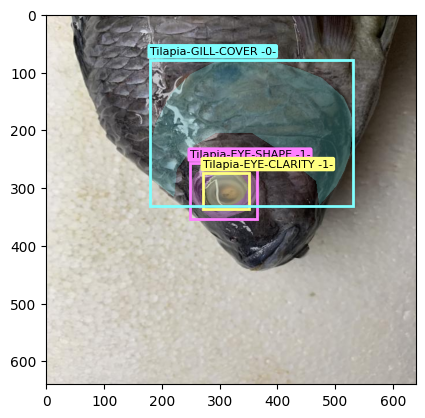

In [ ]:
import json
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image, ImageDraw, ImageFont

# Helper function to normalize colors for Matplotlib
def normalize_color(color):
    return tuple([c / 255 for c in color])

# Define a color map for up to 36 categories based on category ID
CATEGORY_COLORS = {
    0: {"fill": (255, 0, 0, 128), "text_bg": (255, 0, 0), "text": (255, 255, 255)},  # Red with white text
    1: {"fill": (0, 255, 0, 128), "text_bg": (0, 255, 0), "text": (0, 0, 0)},      # Green with black text
    2: {"fill": (0, 0, 255, 128), "text_bg": (0, 0, 255), "text": (255, 255, 255)},  # Blue with white text
    3: {"fill": (255, 255, 0, 128), "text_bg": (255, 255, 0), "text": (0, 0, 0)},  # Yellow with black text
    4: {"fill": (255, 165, 0, 128), "text_bg": (255, 165, 0), "text": (0, 0, 0)},  # Orange with black text
    5: {"fill": (128, 0, 128, 128), "text_bg": (128, 0, 128), "text": (255, 255, 255)},
    6: {"fill": (0, 128, 128, 128), "text_bg": (0, 128, 128), "text": (255, 255, 255)},
    7: {"fill": (128, 128, 0, 128), "text_bg": (128, 128, 0), "text": (255, 255, 255)},
    8: {"fill": (128, 0, 0, 128), "text_bg": (128, 0, 0), "text": (255, 255, 255)},
    9: {"fill": (0, 128, 0, 128), "text_bg": (0, 128, 0), "text": (255, 255, 255)},
    10: {"fill": (0, 0, 128, 128), "text_bg": (0, 0, 128), "text": (255, 255, 255)},
    11: {"fill": (255, 255, 255, 128), "text_bg": (255, 255, 255), "text": (0, 0, 0)},
    12: {"fill": (192, 192, 192, 128), "text_bg": (192, 192, 192), "text": (0, 0, 0)},
    13: {"fill": (128, 128, 128, 128), "text_bg": (128, 128, 128), "text": (0, 0, 0)},
    14: {"fill": (255, 0, 255, 128), "text_bg": (255, 0, 255), "text": (0, 0, 0)},
    15: {"fill": (0, 255, 255, 128), "text_bg": (0, 255, 255), "text": (0, 0, 0)},
    16: {"fill": (255, 255, 128, 128), "text_bg": (255, 255, 128), "text": (0, 0, 0)},
    17: {"fill": (128, 255, 128, 128), "text_bg": (128, 255, 128), "text": (0, 0, 0)},
    18: {"fill": (128, 128, 255, 128), "text_bg": (128, 128, 255), "text": (0, 0, 0)},
    19: {"fill": (255, 128, 128, 128), "text_bg": (255, 128, 128), "text": (0, 0, 0)},
    20: {"fill": (128, 255, 255, 128), "text_bg": (128, 255, 255), "text": (0, 0, 0)},
    21: {"fill": (255, 128, 255, 128), "text_bg": (255, 128, 255), "text": (0, 0, 0)},
    22: {"fill": (255, 255, 128, 128), "text_bg": (255, 255, 128), "text": (0, 0, 0)},
    23: {"fill": (128, 255, 255, 128), "text_bg": (128, 255, 255), "text": (0, 0, 0)},
    24: {"fill": (255, 128, 255, 128), "text_bg": (255, 128, 255), "text": (0, 0, 0)},
    25: {"fill": (255, 255, 128, 128), "text_bg": (255, 255, 128), "text": (0, 0, 0)},
    26: {"fill": (128, 255, 255, 128), "text_bg": (128, 255, 255), "text": (0, 0, 0)},
    27: {"fill": (255, 128, 255, 128), "text_bg": (255, 128, 255), "text": (0, 0, 0)},
    28: {"fill": (255, 255, 128, 128), "text_bg": (255, 255, 128), "text": (0, 0, 0)},
    29: {"fill": (128, 255, 255, 128), "text_bg": (128, 255, 255), "text": (0, 0, 0)},
    30: {"fill": (255, 128, 255, 128), "text_bg": (255, 128, 255), "text": (0, 0, 0)},
    31: {"fill": (255, 255, 128, 128), "text_bg": (255, 255, 128), "text": (0, 0, 0)},
    32: {"fill": (128, 255, 255, 128), "text_bg": (128, 255, 255), "text": (0, 0, 0)},
    33: {"fill": (255, 128, 255, 128), "text_bg": (255, 128, 255), "text": (0, 0, 0)},
    34: {"fill": (255, 255, 128, 128), "text_bg": (255, 255, 128), "text": (0, 0, 0)},
    35: {"fill": (128, 255, 255, 128), "text_bg": (128, 255, 255), "text": (0, 0, 0)},
}

def display_annotations_with_masks(image_path, annotations, target_width, target_height, category_names):
    image = Image.open(image_path)
    original_width, original_height = image.width, image.height

    scale_factor_x = target_width / original_width
    scale_factor_y = target_height / original_height

    scaled_image = image.resize((target_width, target_height))
    fig, ax = plt.subplots()
    ax.imshow(scaled_image)

    mask = Image.new("RGBA", (target_width, target_height), (0, 0, 0, 0))
    draw = ImageDraw.Draw(mask)

    for annotation in annotations:
        category_id = annotation['category_id']
        category_name = category_names.get(category_id, "Unknown")
        color_info = CATEGORY_COLORS.get(
            category_id, {"fill": (255, 255, 255, 128), "text_bg": (0, 0, 0), "text": (255, 255, 255)}
        )

        # Normalize colors for Matplotlib where necessary
        fill_color_normalized = normalize_color(color_info["fill"])
        text_bg_color_normalized = normalize_color(color_info["text_bg"])

        # Draw segmentation polygons
        for seg in annotation['segmentation']:
            scaled_seg = [(seg[i] * scale_factor_x, seg[i + 1] * scale_factor_y) for i in range(0, len(seg), 2)]
            draw.polygon(scaled_seg, outline=color_info["fill"], fill=color_info["fill"])

        # Draw bounding box
        bbox = annotation['bbox']
        scaled_bbox = [bbox[0] * scale_factor_x, bbox[1] * scale_factor_y, bbox[2] * scale_factor_x, bbox[3] * scale_factor_y]
        rect = patches.Rectangle(
            (scaled_bbox[0], scaled_bbox[1]), scaled_bbox[2], scaled_bbox[3],
            linewidth=2, edgecolor=text_bg_color_normalized, facecolor='none'
        )
        ax.add_patch(rect)

        # Add text label with background
        label_pos = (scaled_bbox[0], scaled_bbox[1] - 10)
        plt.text(
            label_pos[0], label_pos[1], category_name,
            color=normalize_color(color_info["text"]),
            fontsize=8,
            bbox=dict(facecolor=text_bg_color_normalized, edgecolor='none', boxstyle="round,pad=0.2")
        )

    # Overlay mask on image
    mask_np = np.array(mask)
    ax.imshow(mask_np, alpha=0.5)

    plt.show()

# Usage example
scaled_json_path = os.path.join(DATASET_PATH, "annotations", "instances_valid.json")
original_image_path = os.path.join(DATASET_PATH, "cleaned", "valid", "1-1-_jpg.rf.6e893289e6f717db2f7ce3d41d8fbe54.jpg")
with open(scaled_json_path) as f:
    scaled_data = json.load(f)

category_names = {cat['id']: cat['name'] for cat in scaled_data['categories']}
image_id = 0
annotations = [ann for ann in scaled_data['annotations'] if ann['image_id'] == image_id]

target_width, target_height = 640, 640
display_annotations_with_masks(original_image_path, annotations, target_width, target_height, category_names)

### True Labels Visualization through Random Selection (Auto)

#### Masked-Contoured

In [17]:
import json
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image, ImageDraw

# Helper function to normalize colors for Matplotlib
def normalize_color(color):
    return tuple([c / 255 for c in color])

# Define a color map for up to 36 categories based on category ID
CATEGORY_COLORS = {
    0: {"fill": (255, 0, 0, 128), "text_bg": (255, 0, 0), "text": (255, 255, 255)},  # Red with white text
    1: {"fill": (0, 255, 0, 128), "text_bg": (0, 255, 0), "text": (0, 0, 0)},      # Green with black text
    2: {"fill": (0, 0, 255, 128), "text_bg": (0, 0, 255), "text": (255, 255, 255)},  # Blue with white text
    3: {"fill": (255, 255, 0, 128), "text_bg": (255, 255, 0), "text": (0, 0, 0)},  # Yellow with black text
    4: {"fill": (255, 165, 0, 128), "text_bg": (255, 165, 0), "text": (0, 0, 0)},  # Orange with black text
    5: {"fill": (128, 0, 128, 128), "text_bg": (128, 0, 128), "text": (255, 255, 255)},
    6: {"fill": (0, 128, 128, 128), "text_bg": (0, 128, 128), "text": (255, 255, 255)},
    7: {"fill": (128, 128, 0, 128), "text_bg": (128, 128, 0), "text": (255, 255, 255)},
    8: {"fill": (128, 0, 0, 128), "text_bg": (128, 0, 0), "text": (255, 255, 255)},
    9: {"fill": (0, 128, 0, 128), "text_bg": (0, 128, 0), "text": (255, 255, 255)},
    10: {"fill": (0, 0, 128, 128), "text_bg": (0, 0, 128), "text": (255, 255, 255)},
    11: {"fill": (255, 255, 255, 128), "text_bg": (255, 255, 255), "text": (0, 0, 0)},
    12: {"fill": (192, 192, 192, 128), "text_bg": (192, 192, 192), "text": (0, 0, 0)},
    13: {"fill": (128, 128, 128, 128), "text_bg": (128, 128, 128), "text": (0, 0, 0)},
    14: {"fill": (255, 0, 255, 128), "text_bg": (255, 0, 255), "text": (0, 0, 0)},
    15: {"fill": (0, 255, 255, 128), "text_bg": (0, 255, 255), "text": (0, 0, 0)},
    16: {"fill": (255, 255, 128, 128), "text_bg": (255, 255, 128), "text": (0, 0, 0)},
    17: {"fill": (128, 255, 128, 128), "text_bg": (128, 255, 128), "text": (0, 0, 0)},
    18: {"fill": (128, 128, 255, 128), "text_bg": (128, 128, 255), "text": (0, 0, 0)},
    19: {"fill": (255, 128, 128, 128), "text_bg": (255, 128, 128), "text": (0, 0, 0)},
    20: {"fill": (128, 255, 255, 128), "text_bg": (128, 255, 255), "text": (0, 0, 0)},
    21: {"fill": (255, 128, 255, 128), "text_bg": (255, 128, 255), "text": (0, 0, 0)},
    22: {"fill": (255, 255, 128, 128), "text_bg": (255, 255, 128), "text": (0, 0, 0)},
    23: {"fill": (128, 255, 255, 128), "text_bg": (128, 255, 255), "text": (0, 0, 0)},
    24: {"fill": (255, 128, 255, 128), "text_bg": (255, 128, 255), "text": (0, 0, 0)},
    25: {"fill": (255, 255, 128, 128), "text_bg": (255, 255, 128), "text": (0, 0, 0)},
    26: {"fill": (128, 255, 255, 128), "text_bg": (128, 255, 255), "text": (0, 0, 0)},
    27: {"fill": (255, 128, 255, 128), "text_bg": (255, 128, 255), "text": (0, 0, 0)},
    28: {"fill": (255, 255, 128, 128), "text_bg": (255, 255, 128), "text": (0, 0, 0)},
    29: {"fill": (128, 255, 255, 128), "text_bg": (128, 255, 255), "text": (0, 0, 0)},
    30: {"fill": (255, 128, 255, 128), "text_bg": (255, 128, 255), "text": (0, 0, 0)},
    31: {"fill": (255, 255, 128, 128), "text_bg": (255, 255, 128), "text": (0, 0, 0)},
    32: {"fill": (128, 255, 255, 128), "text_bg": (128, 255, 255), "text": (0, 0, 0)},
    33: {"fill": (255, 128, 255, 128), "text_bg": (255, 128, 255), "text": (0, 0, 0)},
    34: {"fill": (255, 255, 128, 128), "text_bg": (255, 255, 128), "text": (0, 0, 0)},
    35: {"fill": (128, 255, 255, 128), "text_bg": (128, 255, 255), "text": (0, 0, 0)},
}

def display_random_annotations_grid(scaled_json_path, image_folder, target_width, target_height, num_images=25, grid_size=(5, 5)):
    with open(scaled_json_path) as f:
        scaled_data = json.load(f)

    category_names = {cat['id']: cat['name'] for cat in scaled_data['categories']}

    # Map image IDs to file paths and select random sample
    image_map = {img['id']: img['file_name'] for img in scaled_data['images']}
    selected_image_ids = random.sample(list(image_map.keys()), num_images)

    fig, axs = plt.subplots(grid_size[0], grid_size[1], figsize=(20, 20))
    axs = axs.flatten()

    for idx, image_id in enumerate(selected_image_ids):
        annotations = [ann for ann in scaled_data['annotations'] if ann['image_id'] == image_id]
        image_path = os.path.join(image_folder, image_map[image_id])

        image = Image.open(image_path)
        original_width, original_height = image.width, image.height

        scale_factor_x = target_width / original_width
        scale_factor_y = target_height / original_height

        scaled_image = image.resize((target_width, target_height))
        mask = Image.new("RGBA", (target_width, target_height), (0, 0, 0, 0))
        draw = ImageDraw.Draw(mask)

        for annotation in annotations:
            category_id = annotation['category_id']
            category_name = category_names.get(category_id, "Unknown")
            color_info = CATEGORY_COLORS.get(
                category_id, {"fill": (255, 255, 255, 128), "text_bg": (0, 0, 0), "text": (255, 255, 255)}
            )

            fill_color = normalize_color(color_info["fill"])
            text_bg_color = normalize_color(color_info["text_bg"])

            # Draw mask and outline trace
            for seg in annotation['segmentation']:
                scaled_seg = [(seg[i] * scale_factor_x, seg[i + 1] * scale_factor_y) for i in range(0, len(seg), 2)]
                draw.polygon(scaled_seg, outline=color_info["fill"], fill=color_info["fill"])  # Fill the mask

                # Draw an outline trace around the mask
                axs[idx].plot(
                    [pt[0] for pt in scaled_seg] + [scaled_seg[0][0]],  # Close the path
                    [pt[1] for pt in scaled_seg] + [scaled_seg[0][1]],
                    color=normalize_color(color_info["text_bg"]),
                    linewidth=1.5
                )

            # Position text label near mask
            if scaled_seg:
                label_pos = (scaled_seg[0][0], scaled_seg[0][1] - 10)  # Adjust label position to first point
                axs[idx].text(
                    label_pos[0], label_pos[1], category_name,
                    color=normalize_color(color_info["text"]),
                    fontsize=8,
                    bbox=dict(facecolor=text_bg_color, edgecolor='none', boxstyle="round,pad=0.1")
                )

        # Overlay mask and image on subplot
        mask_np = np.array(mask)
        axs[idx].imshow(scaled_image)
        axs[idx].imshow(mask_np, alpha=0.5)
        axs[idx].axis('on')

    plt.tight_layout()
    plt.show()


# Usage
image_folder = os.path.join(DATASET_PATH,"cleaned", "train")
scaled_json_path = os.path.join(DATASET_PATH, "annotations", "instances_train.json")
display_random_annotations_grid(scaled_json_path, image_folder, target_width=640, target_height=640)

Output hidden; open in https://colab.research.google.com to view.

#### Bounded-Boxed

In [ ]:
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image, ImageDraw

# Helper function to normalize colors for Matplotlib
def normalize_color(color):
    return tuple([c / 255 for c in color])

# Define a color map for up to 36 categories based on category ID
CATEGORY_COLORS = {
    0: {"fill": (255, 0, 0, 128), "text_bg": (255, 0, 0), "text": (255, 255, 255)},  # Red with white text
    1: {"fill": (0, 255, 0, 128), "text_bg": (0, 255, 0), "text": (0, 0, 0)},      # Green with black text
    2: {"fill": (0, 0, 255, 128), "text_bg": (0, 0, 255), "text": (255, 255, 255)},  # Blue with white text
    3: {"fill": (255, 255, 0, 128), "text_bg": (255, 255, 0), "text": (0, 0, 0)},  # Yellow with black text
    4: {"fill": (255, 165, 0, 128), "text_bg": (255, 165, 0), "text": (0, 0, 0)},  # Orange with black text
    5: {"fill": (128, 0, 128, 128), "text_bg": (128, 0, 128), "text": (255, 255, 255)},
    6: {"fill": (0, 128, 128, 128), "text_bg": (0, 128, 128), "text": (255, 255, 255)},
    7: {"fill": (128, 128, 0, 128), "text_bg": (128, 128, 0), "text": (255, 255, 255)},
    8: {"fill": (128, 0, 0, 128), "text_bg": (128, 0, 0), "text": (255, 255, 255)},
    9: {"fill": (0, 128, 0, 128), "text_bg": (0, 128, 0), "text": (255, 255, 255)},
    10: {"fill": (0, 0, 128, 128), "text_bg": (0, 0, 128), "text": (255, 255, 255)},
    11: {"fill": (255, 255, 255, 128), "text_bg": (255, 255, 255), "text": (0, 0, 0)},
    12: {"fill": (192, 192, 192, 128), "text_bg": (192, 192, 192), "text": (0, 0, 0)},
    13: {"fill": (128, 128, 128, 128), "text_bg": (128, 128, 128), "text": (0, 0, 0)},
    14: {"fill": (255, 0, 255, 128), "text_bg": (255, 0, 255), "text": (0, 0, 0)},
    15: {"fill": (0, 255, 255, 128), "text_bg": (0, 255, 255), "text": (0, 0, 0)},
    16: {"fill": (255, 255, 128, 128), "text_bg": (255, 255, 128), "text": (0, 0, 0)},
    17: {"fill": (128, 255, 128, 128), "text_bg": (128, 255, 128), "text": (0, 0, 0)},
    18: {"fill": (128, 128, 255, 128), "text_bg": (128, 128, 255), "text": (0, 0, 0)},
    19: {"fill": (255, 128, 128, 128), "text_bg": (255, 128, 128), "text": (0, 0, 0)},
    20: {"fill": (128, 255, 255, 128), "text_bg": (128, 255, 255), "text": (0, 0, 0)},
    21: {"fill": (255, 128, 255, 128), "text_bg": (255, 128, 255), "text": (0, 0, 0)},
    22: {"fill": (255, 255, 128, 128), "text_bg": (255, 255, 128), "text": (0, 0, 0)},
    23: {"fill": (128, 255, 255, 128), "text_bg": (128, 255, 255), "text": (0, 0, 0)},
    24: {"fill": (255, 128, 255, 128), "text_bg": (255, 128, 255), "text": (0, 0, 0)},
    25: {"fill": (255, 255, 128, 128), "text_bg": (255, 255, 128), "text": (0, 0, 0)},
    26: {"fill": (128, 255, 255, 128), "text_bg": (128, 255, 255), "text": (0, 0, 0)},
    27: {"fill": (255, 128, 255, 128), "text_bg": (255, 128, 255), "text": (0, 0, 0)},
    28: {"fill": (255, 255, 128, 128), "text_bg": (255, 255, 128), "text": (0, 0, 0)},
    29: {"fill": (128, 255, 255, 128), "text_bg": (128, 255, 255), "text": (0, 0, 0)},
    30: {"fill": (255, 128, 255, 128), "text_bg": (255, 128, 255), "text": (0, 0, 0)},
    31: {"fill": (255, 255, 128, 128), "text_bg": (255, 255, 128), "text": (0, 0, 0)},
    32: {"fill": (128, 255, 255, 128), "text_bg": (128, 255, 255), "text": (0, 0, 0)},
    33: {"fill": (255, 128, 255, 128), "text_bg": (255, 128, 255), "text": (0, 0, 0)},
    34: {"fill": (255, 255, 128, 128), "text_bg": (255, 255, 128), "text": (0, 0, 0)},
    35: {"fill": (128, 255, 255, 128), "text_bg": (128, 255, 255), "text": (0, 0, 0)},
}

def display_random_annotations_grid(scaled_json_path, image_folder, target_width, target_height, num_images=25, grid_size=(5, 5)):
    with open(scaled_json_path) as f:
        scaled_data = json.load(f)

    category_names = {cat['id']: cat['name'] for cat in scaled_data['categories']}

    # Map image IDs to file paths and select random sample
    image_map = {img['id']: img['file_name'] for img in scaled_data['images']}
    selected_image_ids = random.sample(list(image_map.keys()), num_images)

    fig, axs = plt.subplots(grid_size[0], grid_size[1], figsize=(20, 20))
    axs = axs.flatten()

    for idx, image_id in enumerate(selected_image_ids):
        annotations = [ann for ann in scaled_data['annotations'] if ann['image_id'] == image_id]
        image_path = os.path.join(image_folder, image_map[image_id])

        image = Image.open(image_path)
        original_width, original_height = image.width, image.height

        scale_factor_x = target_width / original_width
        scale_factor_y = target_height / original_height

        scaled_image = image.resize((target_width, target_height))
        mask = Image.new("RGBA", (target_width, target_height), (0, 0, 0, 0))
        draw = ImageDraw.Draw(mask)

        for annotation in annotations:
            category_id = annotation['category_id']
            category_name = category_names.get(category_id, "Unknown")
            color_info = CATEGORY_COLORS.get(
                category_id, {"fill": (255, 255, 255, 128), "text_bg": (0, 0, 0), "text": (255, 255, 255)}
            )

            fill_color = normalize_color(color_info["fill"])
            text_bg_color = normalize_color(color_info["text_bg"])

            for seg in annotation['segmentation']:
                scaled_seg = [(seg[i] * scale_factor_x, seg[i + 1] * scale_factor_y) for i in range(0, len(seg), 2)]
                draw.polygon(scaled_seg, outline=color_info["fill"], fill=color_info["fill"])

            bbox = annotation['bbox']
            scaled_bbox = [bbox[0] * scale_factor_x, bbox[1] * scale_factor_y, bbox[2] * scale_factor_x, bbox[3] * scale_factor_y]
            rect = patches.Rectangle(
                (scaled_bbox[0], scaled_bbox[1]), scaled_bbox[2], scaled_bbox[3],
                linewidth=2, edgecolor=text_bg_color, facecolor='none'
            )
            axs[idx].add_patch(rect)

            label_pos = (scaled_bbox[0], scaled_bbox[1] - 10)
            axs[idx].text(
                label_pos[0], label_pos[1], category_name,
                color=normalize_color(color_info["text"]),
                fontsize=8,
                bbox=dict(facecolor=text_bg_color, edgecolor='none', boxstyle="round,pad=0.1")
            )

        mask_np = np.array(mask)
        axs[idx].imshow(scaled_image)
        axs[idx].imshow(mask_np, alpha=0.5)
        axs[idx].axis('off')

    plt.tight_layout()
    plt.show()

# Usage
scaled_json_path = os.path.join(DATASET_PATH, "annotations", "instances_valid.json")
image_folder = os.path.join(DATASET_PATH,"cleaned", "valid")
display_random_annotations_grid(scaled_json_path, image_folder, target_width=640, target_height=640)

Output hidden; open in https://colab.research.google.com to view.

### Data Augmentations & Normalization

In [ ]:
# ....

## Training Phase

### Imports and Custom Dataset Setup
> This cell will include all necessary imports and the custom dataset class definition.

In [21]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor
from pycocotools.coco import COCO
from PIL import Image
import numpy as np

# Custom COCO Dataset class
class COCODataset(Dataset):
    def __init__(self, image_dir, annotation_file, transforms=None):
        self.image_dir = image_dir
        self.coco = COCO(annotation_file)
        self.image_ids = list(self.coco.imgs.keys())
        self.transforms = transforms

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        # Load image ID and image
        image_id = self.image_ids[idx]
        image_info = self.coco.loadImgs(image_id)[0]
        img_path = os.path.join(self.image_dir, image_info['file_name'])
        image = Image.open(img_path).convert("RGB")

        # Load annotations
        annotations = self.coco.loadAnns(self.coco.getAnnIds(imgIds=image_id))

        # Extract boxes, labels, and masks
        boxes = []
        labels = []
        masks = []

        for annotation in annotations:
            # Bounding box
            xmin, ymin, width, height = annotation['bbox']
            boxes.append([xmin, ymin, xmin + width, ymin + height])

            # Category ID (label)
            labels.append(annotation['category_id'])

            # Segmentation mask
            if 'segmentation' in annotation:
                mask = self.coco.annToMask(annotation)
                masks.append(mask)

        # Convert to tensors
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        masks = torch.as_tensor(np.stack(masks), dtype=torch.uint8)

        target = {
            "boxes": boxes,
            "labels": labels,
            "masks": masks,
            "image_id": torch.tensor([image_id])
        }

        if self.transforms:
            image = self.transforms(image)

        return image, target

### Data Paths and DataLoader Setup
> Definition of paths/routes to dataset and initialization of Train and Validation DataLoader.

In [22]:
# Define paths for training and validation datasets
train_image_dir = os.path.join(DATASET_PATH, "cleaned", "train")
train_annotation_file = os.path.join(DATASET_PATH, "annotations", "instances_train.json")  # COCO-format JSON for training

val_image_dir = os.path.join(DATASET_PATH, "cleaned" ,"valid")
val_annotation_file = os.path.join(DATASET_PATH, "annotations", "instances_valid.json")  # COCO-format JSON for validation

# Initialize the datasets and DataLoaders
train_dataset = COCODataset(image_dir=train_image_dir, annotation_file=train_annotation_file, transforms=ToTensor())
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))

valid_dataset = COCODataset(image_dir=val_image_dir, annotation_file=val_annotation_file, transforms=ToTensor())
valid_loader = DataLoader(valid_dataset, batch_size=2, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))

loading annotations into memory...
Done (t=0.06s)
creating index...
index created!
loading annotations into memory...
Done (t=0.30s)
creating index...
index created!


### Training Loop
> This cell will train the model. We re-run it as needed especially if we want to continue training for more epochs.

In [ ]:
import os
import re
import json
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.models.detection import maskrcnn_resnet50_fpn
from torchvision.transforms import ToTensor
from pycocotools.coco import COCO
from PIL import Image
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt

# Base directory for versioned models and logs
save_dir = MODELS_PATH

# Define current model configuration and hyperparameters
config = {
    'model': 'MaskRCNN',
    'backbone': 'resnet50_fpn',
    'dataset': 'AquaGrade_CustomDataset_v1',
    'learning_rate': 0.005,
    'batch_size': 16,
}

# Load, save, and compare configurations
def load_previous_config(path):
    try:
        with open(path, 'r') as f:
            return json.load(f)
    except FileNotFoundError:
        return {}

def save_config(path, config):
    with open(path, 'w') as f:
        json.dump(config, f, indent=4)

def determine_version_type(current_config, previous_config):
    major_keys = ['model', 'backbone', 'dataset']
    minor_keys = ['learning_rate', 'batch_size']

    if any(current_config.get(key) != previous_config.get(key) for key in major_keys):
        return "major"
    elif any(current_config.get(key) != previous_config.get(key) for key in minor_keys):
        return "minor"
    else:
        return "patch"

# Get the latest version
def get_latest_version(directory, base_name="AquaGrade_MaskRCNN"):
    pattern = re.compile(rf"{base_name}_v(\d+)\.(\d+)\.(\d+)")
    versions = []

    for folder in os.listdir(directory):
        match = pattern.match(folder)
        if match:
            versions.append(tuple(map(int, match.groups())))

    if versions:
        return max(versions)  # Latest version by sorting
    return (0, 0, 0)  # Initial version if no folders found

# Save model checkpoint or final model version
def save_model(model, optimizer, epoch, loss, directory, version_type="patch", is_final=False):
    major, minor, patch = get_latest_version(directory)

    if version_type == "major":
        major += 1
        minor = 0
        patch = 0
    elif version_type == "minor":
        minor += 1
        patch = 0
    elif version_type == "patch":
        patch += 1

    versioned_folder = os.path.join(directory, f"AquaGrade_MaskRCNN_v{major}.{minor}.{patch}")
    os.makedirs(versioned_folder, exist_ok=True)

    model_folder = "final_model" if is_final else "checkpoints"
    save_folder = os.path.join(versioned_folder, model_folder)
    os.makedirs(save_folder, exist_ok=True)

    file_name = "final_model.pth" if is_final else f"checkpoint_epoch_{epoch}.pth"
    checkpoint_path = os.path.join(save_folder, file_name)
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss,
    }, checkpoint_path)

    print(f"Saved {'final model' if is_final else 'checkpoint'} in folder: {save_folder}")

# Custom COCO Dataset class
class COCODataset(Dataset):
    def __init__(self, image_dir, annotation_file, transforms=None):
        self.image_dir = image_dir
        self.coco = COCO(annotation_file)
        self.image_ids = list(self.coco.imgs.keys())
        self.transforms = transforms

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        image_id = self.image_ids[idx]
        image_info = self.coco.loadImgs(image_id)[0]
        img_path = os.path.join(self.image_dir, image_info['file_name'])
        image = Image.open(img_path).convert("RGB")

        annotations = self.coco.loadAnns(self.coco.getAnnIds(imgIds=image_id))
        boxes, labels, masks = [], [], []

        for annotation in annotations:
            xmin, ymin, width, height = annotation['bbox']
            boxes.append([xmin, ymin, xmin + width, ymin + height])
            labels.append(annotation['category_id'])

            if 'segmentation' in annotation:
                mask = self.coco.annToMask(annotation)
                masks.append(mask)

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        masks = torch.as_tensor(np.stack(masks), dtype=torch.uint8)

        target = {
            "boxes": boxes,
            "labels": labels,
            "masks": masks,
            "image_id": torch.tensor([image_id])
        }

        if self.transforms:
            image = self.transforms(image)

        return image, target

# Function to calculate evaluation metrics
def calculate_metrics(all_true_labels, all_predicted_labels):
    precision = precision_score(all_true_labels, all_predicted_labels, average='weighted', zero_division=0)
    recall = recall_score(all_true_labels, all_predicted_labels, average='weighted', zero_division=0)
    f1 = f1_score(all_true_labels, all_predicted_labels, average='weighted', zero_division=0)
    accuracy = accuracy_score(all_true_labels, all_predicted_labels)
    conf_matrix = confusion_matrix(all_true_labels, all_predicted_labels)

    return precision, recall, f1, accuracy, conf_matrix

# Save metrics to file
def save_metrics(metrics, version_folder):
    metrics_path = os.path.join(version_folder, "metrics.json")
    with open(metrics_path, "w") as f:
        json.dump(metrics, f, indent=4)

    print(f"Metrics saved at: {metrics_path}")

# Create confusion matrix plot
def plot_confusion_matrix(conf_matrix, version_folder):
    plt.figure(figsize=(8, 6))
    plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(set(all_true_labels)))  # Adjust based on your classes
    plt.xticks(tick_marks, tick_marks)
    plt.yticks(tick_marks, tick_marks)

    # Add labels
    thresh = conf_matrix.max() / 2.
    for i, j in np.ndindex(conf_matrix.shape):
        plt.text(j, i, format(conf_matrix[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if conf_matrix[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

    # Save the plot
    plt_path = os.path.join(version_folder, "confusion_matrix.png")
    plt.savefig(plt_path)
    plt.close()
    print(f"Confusion matrix saved at: {plt_path}")

# Define paths for training and validation datasets
train_image_dir = os.path.join(DATASET_PATH, "cleaned", "train")
train_annotation_file = os.path.join(DATASET_PATH, "annotations", "instances_train.json")

val_image_dir = os.path.join(DATASET_PATH, "cleaned", "valid")
val_annotation_file = os.path.join(DATASET_PATH, "annotations", "instances_valid.json")

# Initialize the datasets and DataLoaders
train_dataset = COCODataset(image_dir=train_image_dir, annotation_file=train_annotation_file, transforms=ToTensor())
train_loader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True, collate_fn=lambda x: tuple(zip(*x)))

valid_dataset = COCODataset(image_dir=val_image_dir, annotation_file=val_annotation_file, transforms=ToTensor())
valid_loader = DataLoader(valid_dataset, batch_size=config['batch_size'], shuffle=False, collate_fn=lambda x: tuple(zip(*x)))

# Initialize model and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = maskrcnn_resnet50_fpn(pretrained=True)
model.to(device)
model.train()
optimizer = torch.optim.SGD(model.parameters(), lr=config['learning_rate'], momentum=0.9, weight_decay=0.0005)

# Configuration management and versioning
config_path = os.path.join(save_dir, "config.json")
previous_config = load_previous_config(config_path)
version_type = determine_version_type(config, previous_config)
save_config(config_path, config)

# EarlyStopping class definition
class EarlyStopping:
    def __init__(self, patience=5, verbose=False):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_loss = float('inf')
        self.early_stop = False

    def __call__(self, val_loss):
        if val_loss < self.best_loss:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
                if self.verbose:
                    print(f"Early stopping triggered after {self.patience} epochs without improvement.")

# Training loop
num_epochs = 10  # Set a larger number for epochs
early_stopping = EarlyStopping(patience=3, verbose=True)
best_val_loss = float('inf')

for epoch in range(num_epochs):
    # Training phase
    model.train()
    total_loss = 0

    for images, targets in train_loader:
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        total_loss += losses.item()

    avg_train_loss = total_loss / len(train_loader)

    # Validation phase
    model.eval()
    val_loss = 0
    all_true_labels = []
    all_predicted_labels = []

    with torch.no_grad():
        for val_images, val_targets in valid_loader:
            val_images = list(image.to(device) for image in val_images)
            val_targets = [{k: v.to(device) for k, v in t.items()} for t in val_targets]
            val_loss_dict = model(val_images, val_targets)
            val_loss += sum(loss for loss in val_loss_dict.values()).item()

            # Gather true and predicted labels for metrics
            for target in val_targets:
                all_true_labels.extend(target['labels'].cpu().numpy())
            for output in model(val_images):
                all_predicted_labels.extend(output['labels'].cpu().numpy())

    avg_val_loss = val_loss / len(valid_loader)

    # Calculate metrics
    precision, recall, f1, accuracy, conf_matrix = calculate_metrics(all_true_labels, all_predicted_labels)

    # Create versioned results folder
    version_folder = os.path.join(save_dir, f"{version_type}_results")
    os.makedirs(version_folder, exist_ok=True)

    # Save metrics
    metrics = {
        "epoch": epoch,
        "avg_val_loss": avg_val_loss,
        "precision": precision,
        "recall": recall,
        "f1_score": f1,
        "accuracy": accuracy,
        "confusion_matrix": conf_matrix.tolist()  # Convert numpy array to list for JSON serialization
    }
    save_metrics(metrics, version_folder)

    # Plot and save confusion matrix
    plot_confusion_matrix(conf_matrix, version_folder)

    # Save the best model based on validation performance
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        save_model(model, optimizer, epoch, best_val_loss, save_dir, version_type=version_type, is_final=True)

    # Check for early stopping
    early_stopping(avg_val_loss)
    if early_stopping.early_stop:
        print("Early stopping initiated. Training stopped.")
        break

print("Training complete.")


### Evaluation Loop
> Running this evaluation cell will help us see the model’s predictions. This cell will run the model in evaluation mode and output bounding boxes, labels, scores, and masks.

In [ ]:
# Evaluation loop
model.eval()
with torch.no_grad():
    for images, _ in train_loader:  # Replace with validation DataLoader if available
        images = list(img for img in images)
        predictions = model(images)

        # Output predictions for each image
        for i, prediction in enumerate(predictions):
            print(f"Image {i + 1}")
            print("Bounding Boxes:", prediction["boxes"])  # Bounding box coordinates
            print("Labels:", prediction["labels"])         # Class labels
            print("Scores:", prediction["scores"])         # Confidence scores
            print("Masks:", prediction["masks"])           # Segmentation masks

## Testing Phase

_this section tests the TRAINED MODEL against UNSEEN DATA both static and realtime_

### Insert an Image Approach Inference OR Folder of Images

In [ ]:
import tkinter as tk
from tkinter import filedialog, messagebox, ttk
from ultralytics import YOLO
from PIL import Image, ImageTk
import numpy as np
import cv2
import os
import math
import sys


def create_image_grid(image_folder, grid_size=(5, 5)):
    """Create a grid of images from the output folder."""
    images = [img for img in os.listdir(
        image_folder) if img.startswith("output_")]
    if not images:
        print("No output images found.")
        return None

    n = min(len(images), grid_size[0] * grid_size[1])
    rows = min(grid_size[0], math.ceil(math.sqrt(n)))
    cols = min(grid_size[1], math.ceil(n / rows))

    with Image.open(os.path.join(image_folder, images[0])) as img:
        w, h = img.size

    grid_img = Image.new('RGB', (cols * w, rows * h), color='white')

    for i, image in enumerate(images[:n]):
        with Image.open(os.path.join(image_folder, image)) as img:
            grid_img.paste(img, ((i % cols) * w, (i // cols) * h))

    return grid_img


def load_model(model_path):
    """Load the YOLOv8 model."""
    try:
        return YOLO(model_path)
    except Exception as e:
        print(f"Error loading model: {e}")
        sys.exit(1)


def perform_inference(model, image_path):
    """Perform inference on the given image."""
    try:
        results = model(image_path)
        return results[0]
    except Exception as e:
        print(f"Error during inference: {e}")
        return None


def visualize_results(image_path, results):
    """Visualize the results on the image."""
    try:
        img = cv2.imread(image_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        result_plot = results.plot()
        return Image.fromarray(result_plot)
    except Exception as e:
        print(f"Error visualizing results: {e}")
        return None


def process_detections(results):
    """Process and return detection data."""
    detections = []
    for box in results.boxes:
        detections.append({
            'box': box.xyxy[0].tolist(),
            'confidence': float(box.conf[0]),
            'class': int(box.cls[0])
        })
    return detections


def safe_save(image, output_path):
    """Save the image with a unique filename to avoid overwriting."""
    base, ext = os.path.splitext(output_path)
    counter = 1
    while os.path.exists(output_path):
        output_path = f"{base}_{counter}{ext}"
        counter += 1
    image.save(output_path)
    return output_path


def process_image(model, image_path, output_folder):
    """Process a single image."""
    results = perform_inference(model, image_path)
    if results is None:
        return

    result_image = visualize_results(image_path, results)
    if result_image is None:
        return

    filename = os.path.basename(image_path)
    output_path = os.path.join(output_folder, f"output_{filename}")
    saved_path = safe_save(result_image, output_path)
    print(f"Result image saved as '{saved_path}'")

    detections = process_detections(results)
    print(f"Detections for {filename}:")
    for detection in detections:
        print(f"Box: {detection['box']}")
        print(f"Confidence: {detection['confidence']}")
        print(f"Class: {detection['class']}")
        print("---")
    print("\n")


def process_folder(model, folder_path, output_folder):
    """Process all images in the specified folder."""
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    for filename in os.listdir(folder_path):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.tiff', '.bmp', '.gif')):
            image_path = os.path.join(folder_path, filename)
            process_image(model, image_path, output_folder)


def get_next_grid_number():
    i = 1
    while os.path.exists(f"image_grid_output_{i}.jpg"):
        i += 1
    return i


class YOLOApp:
    def __init__(self, master):
        self.master = master
        master.title("HOOKit pre-release v0.3")
        master.geometry("500x700")

        self.model = None
        self.current_image = None
        self.output_folder = None

        # Create main frame
        main_frame = ttk.Frame(master, padding="10")
        main_frame.grid(row=0, column=0, sticky=(tk.W, tk.E, tk.N, tk.S))
        master.columnconfigure(0, weight=1)
        master.rowconfigure(0, weight=1)

        # Model container
        model_frame = ttk.LabelFrame(
            main_frame, text="Model Selection", padding="10")
        model_frame.grid(row=0, column=0, columnspan=2,
                         sticky=(tk.W, tk.E), pady=5)
        model_frame.columnconfigure(1, weight=1)

        self.model_button = ttk.Button(
            model_frame, text="Load Model", command=self.load_model)
        self.model_button.grid(row=0, column=0, sticky=tk.W)

        self.current_model_label = ttk.Label(
            model_frame, text="Current Model: None")
        self.current_model_label.grid(
            row=0, column=1, sticky=tk.W, padx=(10, 0))

        # Image selection container
        image_frame = ttk.LabelFrame(
            main_frame, text="Image Selection", padding="10")
        image_frame.grid(row=1, column=0, sticky=(tk.W, tk.E), pady=5)
        image_frame.columnconfigure(1, weight=1)

        self.image_button = ttk.Button(
            image_frame, text="Choose Image", command=self.load_image)
        self.image_button.grid(row=0, column=0, sticky=tk.W)

        self.current_image_label = ttk.Label(
            image_frame, text="No image selected")
        self.current_image_label.grid(
            row=0, column=1, sticky=tk.W, padx=(10, 0))

        # Output folder container
        output_frame = ttk.LabelFrame(
            main_frame, text="Output Folder", padding="10")
        output_frame.grid(row=1, column=1, sticky=(tk.W, tk.E), pady=5)
        output_frame.columnconfigure(1, weight=1)

        self.output_button = ttk.Button(
            output_frame, text="Set Output Folder", command=self.set_output_folder)
        self.output_button.grid(row=0, column=0, sticky=tk.W)

        self.output_label = ttk.Label(output_frame, text="No folder selected")
        self.output_label.grid(row=0, column=1, sticky=tk.W, padx=(10, 0))

        # Infer container
        infer_frame = ttk.LabelFrame(
            main_frame, text="Inference", padding="10")
        infer_frame.grid(row=2, column=0, columnspan=2,
                         sticky=(tk.W, tk.E), pady=5)

        self.infer_button = ttk.Button(
            infer_frame, text="Infer Now", command=self.infer_now, state=tk.DISABLED)
        self.infer_button.pack()

        # Folder processing container
        folder_frame = ttk.LabelFrame(
            main_frame, text="Multiple Image Processing", padding="10")
        folder_frame.grid(row=3, column=0, columnspan=2,
                          sticky=(tk.W, tk.E), pady=5)

        self.folder_button = ttk.Button(
            folder_frame, text="Select a Folder", command=self.process_folder)
        self.folder_button.pack()

        # Real-time inference container
        realtime_frame = ttk.LabelFrame(
            main_frame, text="Real-time Inference", padding="10")
        realtime_frame.grid(row=4, column=0, columnspan=2,
                            sticky=(tk.W, tk.E), pady=5)

        self.realtime_button = ttk.Button(
            realtime_frame, text="Start Real-time Inference", command=self.toggle_realtime_inference)
        self.realtime_button.pack()

        self.camera_var = tk.StringVar()
        self.camera_dropdown = ttk.Combobox(
            realtime_frame, textvariable=self.camera_var)
        self.camera_dropdown.pack(pady=5)
        self.update_camera_list()

        # Add a label to display the webcam feed
        self.video_label = ttk.Label(main_frame)
        self.video_label.grid(row=5, column=0, columnspan=2, pady=5)

        # Initialize webcam variables
        self.cap = None
        self.is_realtime_active = False

    def load_model(self):
        model_path = filedialog.askopenfilename(
            filetypes=[("YOLO Model", "*.pt")])
        if model_path:
            try:
                self.model = load_model(model_path)
                model_name = os.path.basename(model_path)
                self.current_model_label.config(
                    text=f"Current Model: {model_name}")
                messagebox.showinfo("Success", "Model loaded successfully!")
            except Exception as e:
                messagebox.showerror(
                    "Error", f"Failed to load model: {str(e)}")

    def load_image(self):
        image_path = filedialog.askopenfilename(
            filetypes=[("Image files", "*.png *.jpg *.jpeg *.tiff *.bmp *.gif")])
        if image_path:
            self.current_image = image_path
            self.current_image_label.config(text=os.path.basename(image_path))
            self.infer_button.config(state=tk.NORMAL)
            messagebox.showinfo("Success", "Image loaded successfully!")

    def set_output_folder(self):
        self.output_folder = filedialog.askdirectory()
        if self.output_folder:
            self.output_label.config(text=os.path.basename(self.output_folder))
            messagebox.showinfo("Success", "Output folder set successfully!")

    def infer_now(self):
        if not self.model:
            messagebox.showerror("Error", "Please load a model first.")
            return
        if not self.output_folder:
            messagebox.showerror(
                "Error", "Please select an output folder first.")
            return
        if not self.current_image:
            messagebox.showerror("Error", "Please load an image first.")
            return

        process_image(self.model, self.current_image, self.output_folder)
        messagebox.showinfo("Success", "Image processed successfully!")

    def process_folder(self):
        if not self.model:
            messagebox.showerror("Error", "Please load a model first.")
            return
        if not self.output_folder:
            messagebox.showerror(
                "Error", "Please select an output folder first.")
            return

        folder_path = filedialog.askdirectory()
        if folder_path:
            process_folder(self.model, folder_path, self.output_folder)
            grid_image = create_image_grid(
                self.output_folder, grid_size=(5, 5))
            if grid_image:
                grid_number = get_next_grid_number()
                grid_filename = f"image_grid_output_{grid_number}.jpg"
                grid_image.save(os.path.join(
                    self.output_folder, grid_filename))
                messagebox.showinfo(
                    "Success", f"Folder processed and grid image saved as '{grid_filename}'")
            else:
                messagebox.showinfo(
                    "Success", "Folder processed successfully!")

    def list_available_cameras(self):
        index = 0
        cameras = []
        while True:
            cap = cv2.VideoCapture(index)
            if not cap.read()[0]:
                break
            else:
                cameras.append(index)
            cap.release()
            index += 1
        return cameras

    def update_camera_list(self):
        cameras = self.list_available_cameras()
        self.camera_dropdown['values'] = [f"Camera {i}" for i in cameras]
        if cameras:
            self.camera_dropdown.set(f"Camera {cameras[0]}")

    def toggle_realtime_inference(self):
        if not self.model:
            messagebox.showerror("Error", "Please load a model first.")
            return

        if self.is_realtime_active:
            self.stop_realtime_inference()
        else:
            self.start_realtime_inference()

    def start_realtime_inference(self):
        camera_index = int(self.camera_var.get().split()[-1])
        self.cap = cv2.VideoCapture(camera_index)
        if not self.cap.isOpened():
            messagebox.showerror(
                "Error", f"Failed to open camera {camera_index}")
            return
        self.is_realtime_active = True
        self.realtime_button.config(text="Stop Real-time Inference")
        self.update_webcam()

    def stop_realtime_inference(self):
        if self.cap:
            self.cap.release()
        self.is_realtime_active = False
        self.realtime_button.config(text="Start Real-time Inference")
        self.video_label.config(image='')

    def update_webcam(self):
        if self.is_realtime_active:
            ret, frame = self.cap.read()
            if ret:
                results = self.model(frame)
                result_frame = results[0].plot()
                img = Image.fromarray(cv2.cvtColor(
                    result_frame, cv2.COLOR_BGR2RGB))
                img = ImageTk.PhotoImage(img)
                self.video_label.config(image=img)
                self.video_label.image = img
            self.master.after(10, self.update_webcam)

    def on_closing(self):
        if self.cap:
            self.cap.release()
        self.master.destroy()


def main():
    root = tk.Tk()
    app = YOLOApp(root)
    root.protocol("WM_DELETE_WINDOW", app.on_closing)
    root.mainloop()


if __name__ == "__main__":
    main()

In [ ]:
from PIL import Image, ImageTk

### Inference via Realtime Camera

In [ ]:
%pip install ultralytics opencv-python

from ultralytics import YOLO
import cv2

# Load the newly custom trained model
model = YOLO(MODEL_PATH)

# Open the laptop camera
cap = cv2.VideoCapture(1)

while True:
    # Read a frame from the camera
    ret, frame = cap.read()

    if not ret:
        break

    # Run inference on the frame
    results = model(frame)

    # Visualize the results on the frame
    annotated_frame = results[0].plot()

    # Display the annotated frame
    cv2.imshow("HOOKitModel-pre-v0.3", annotated_frame)

    # Break the loop if 'q' is pressed
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release the camera and close windows
cap.release()
cv2.destroyAllWindows()

## Pre-Deployment Phase

### Export the Base Model Summary into a .DOCX File

In [ ]:
# Parse the data
data = []
for line in """from n params module arguments
0 -1 1 464 ultralytics.nn.modules.conv.Conv [3, 16, 3, 2]
1 -1 1 4672 ultralytics.nn.modules.conv.Conv [16, 32, 3, 2]
2 -1 1 7360 ultralytics.nn.modules.block.C2f [32, 32, 1, True]
3 -1 1 18560 ultralytics.nn.modules.conv.Conv [32, 64, 3, 2]
4 -1 2 49664 ultralytics.nn.modules.block.C2f [64, 64, 2, True]
5 -1 1 73984 ultralytics.nn.modules.conv.Conv [64, 128, 3, 2]
6 -1 2 197632 ultralytics.nn.modules.block.C2f [128, 128, 2, True]
7 -1 1 295424 ultralytics.nn.modules.conv.Conv [128, 256, 3, 2]
8 -1 1 460288 ultralytics.nn.modules.block.C2f [256, 256, 1, True]
9 -1 1 164608 ultralytics.nn.modules.block.SPPF [256, 256, 5]
10 -1 1 0 torch.nn.modules.upsampling.Upsample [None, 2, 'nearest']
11 [-1, 6] 1 0 ultralytics.nn.modules.conv.Concat [1]
12 -1 1 148224 ultralytics.nn.modules.block.C2f [384, 128, 1]
13 -1 1 0 torch.nn.modules.upsampling.Upsample [None, 2, 'nearest']
14 [-1, 4] 1 0 ultralytics.nn.modules.conv.Concat [1]
15 -1 1 37248 ultralytics.nn.modules.block.C2f [192, 64, 1]
16 -1 1 36992 ultralytics.nn.modules.conv.Conv [64, 64, 3, 2]
17 [-1, 12] 1 0 ultralytics.nn.modules.conv.Concat [1]
18 -1 1 123648 ultralytics.nn.modules.block.C2f [192, 128, 1]
19 -1 1 147712 ultralytics.nn.modules.conv.Conv [128, 128, 3, 2]""".split('\n')[1:]:  # Skip the header
    parts = line.split()
    data.append({
        'n': parts[0],
        'from': parts[1],
        'params': parts[3],
        'module': parts[4],
        'arguments': ' '.join(parts[5:])
    })

# Create a pandas DataFrame
df = pd.DataFrame(data)

# Create a new Word document
doc = Document()

# Add a title
doc.add_heading('Model Summary', 0)

# Add the table
table = doc.add_table(rows=1, cols=5)
table.style = 'Table Grid'

# Add the header row
header_cells = table.rows[0].cells
header_cells[0].text = 'n'
header_cells[1].text = 'from'
header_cells[2].text = 'params'
header_cells[3].text = 'module'
header_cells[4].text = 'arguments'

# Add the data rows
for _, row in df.iterrows():
    cells = table.add_row().cells
    cells[0].text = row['n']
    cells[1].text = row['from']
    cells[2].text = row['params']
    cells[3].text = row['module']
    cells[4].text = row['arguments']

# Add the summary
doc.add_paragraph(
    '\nModel summary: 225 layers, 3014748 parameters, 3014732 gradients, 8.2 GFLOPs')

# Save the document
doc.save('model_summary.docx')

print("Document 'model_summary.docx' has been created.")

### Convert and Export Trained Model to ONNX

In [ ]:
import tensorflow.keras as tf_keras

# Select what format to be EXPORTED
print("Select the format you want to export to: \n\t 1. ONNX \n\t 2. TFLite \n\t 3. CoreML")

try:
    model_format = int(input())

    if model_format == 1:
        model_format = "onnx"
    elif model_format == 2:
        model_format = "tflite"
    elif model_format == 3:
        model_format = "coreml"
    else:
        raise ValueError
except ValueError:
    raise ValueError("Wrong format selected, please select 1 or 2 or 3 only.")

# Load your model

model = YOLO(MODEL_PATH)
print(f"Model was successfully loaded from {MODEL_PATH}!")
print(f"We're now EXPORTING your model to {model_format.upper()} format!")


# Export the model to whatever chosen
model.export(format=model_format)

print(f"Model was successfully exported to {format}!")

### Validate the ONNX Model's Formation

In [ ]:
# Load the ONNX model
onnx_model = onnx.load(ONNX_PATH)

# Check that the model if it is well formed
onnx.checker.check_model(onnx_model)

print("Model was successfully converted to ONNX and is well-formed!")

## Utilities

### AquaGrade's Smart Nitpicker of Dataspecimen

In [ ]:
import os
import shutil
import random
from tkinter import Tk, filedialog, messagebox, Label
from PIL import Image, ImageTk

COPIED_IMAGES_FILE = "copied_images.txt"


def select_folder(root):
    while True:
        folder_path = filedialog.askdirectory(
            title="Select folder containing images")
        if folder_path:
            return folder_path
        else:
            if messagebox.askokcancel("Exit", "No folder selected. Do you want to exit?"):
                root.quit()
                return None


def create_new_folder(parent_path):
    while True:
        new_folder_name = input(
            "Enter a name for the destination folder (default: Copied_Images): ").strip()
        if not new_folder_name:
            new_folder_name = "Copied_Images"
        new_folder_path = os.path.join(parent_path, new_folder_name)
        try:
            os.makedirs(new_folder_path, exist_ok=True)
            return new_folder_path
        except PermissionError:
            print("Permission denied. Please choose a different name.")
        except OSError as e:
            print(f"Error creating folder: {e}")


def get_file_types():
    print("Select file types to copy (separate with commas):")
    print("1. PNG")
    print("2. JPG/JPEG")
    print("3. GIF")
    print("4. BMP")
    print("5. All of the above")
    choice = input("Enter your choices (e.g., 1,2,3): ")
    types = {
        '1': '.png', '2': ('.jpg', '.jpeg'), '3': '.gif', '4': '.bmp',
        '5': ('.png', '.jpg', '.jpeg', '.gif', '.bmp')
    }
    selected = set()
    for c in choice.split(','):
        selected.update(types.get(c.strip(), ()))
    return selected


def load_copied_images():
    if os.path.exists(COPIED_IMAGES_FILE):
        with open(COPIED_IMAGES_FILE, "r") as f:
            return set(line.strip() for line in f)
    return set()


def save_copied_image(image_name):
    with open(COPIED_IMAGES_FILE, "a") as f:
        f.write(f"{image_name}\n")


def copy_random_images(source_folder, destination_folder, num_images, file_types):
    copied_images_set = load_copied_images()
    image_files = [f for f in os.listdir(source_folder)
                   if os.path.splitext(f.lower())[1] in file_types and f not in copied_images_set]

    if not image_files:
        print("No matching image files found in the selected folder.")
        return []

    num_to_copy = min(num_images, len(image_files))
    selected_images = random.sample(image_files, num_to_copy)

    copied_images = []
    for image in selected_images:
        source_path = os.path.join(source_folder, image)
        destination_path = os.path.join(destination_folder, image)
        try:
            shutil.copy2(source_path, destination_path)
            copied_images.append(destination_path)
            save_copied_image(image)
            print(f"Copied '{image}' to '{destination_folder}'")
        except (PermissionError, OSError) as e:
            print(f"Error copying '{image}': {e}")

    print(f"Copied {len(copied_images)} out of {
          num_to_copy} requested images to '{destination_folder}'")
    return copied_images


def get_number_of_images():
    while True:
        try:
            num = int(input("How many images would you like to copy? "))
            if num > 0:
                return num
            else:
                print("Please enter a positive number.")
        except ValueError:
            print("Please enter a valid number.")


def preview_images(root, image_paths):
    root.deiconify()  # Make sure the window is visible
    root.title("Image Preview")

    for i, path in enumerate(image_paths):
        try:
            img = Image.open(path)
            img.thumbnail((100, 100))
            photo = ImageTk.PhotoImage(img)
            label = Label(root, image=photo)
            label.image = photo
            label.grid(row=i//5, column=i % 5, padx=5, pady=5)
        except Exception as e:
            print(f"Error previewing image {path}: {e}")


def on_closing():
    if os.path.exists(COPIED_IMAGES_FILE):
        os.remove(COPIED_IMAGES_FILE)
    root.destroy()


def main():
    global root
    root = Tk()

    while True:
        source_folder = select_folder(root)
        if not source_folder:
            print("Exiting the program.")
            return

        num_images = get_number_of_images()
        file_types = get_file_types()

        parent_folder = os.path.dirname(source_folder)
        new_folder = create_new_folder(parent_folder)

        copied_images = copy_random_images(
            source_folder, new_folder, num_images, file_types)

        if copied_images:
            preview_images(root, copied_images)

        if messagebox.askyesno("Repeat", "Do you want to select another folder and copy more images?"):
            continue
        else:
            break

    root.protocol("WM_DELETE_WINDOW", on_closing)
    root.mainloop()


if __name__ == "__main__":
    main()

### AquaGrade's Folder Image Division

In [ ]:
import os
import shutil
import math
import tkinter as tk
from tkinter import filedialog, messagebox


def divide_images():
    source_folder = source_entry.get()
    destination_folder = dest_entry.get()

    try:
        num_divisions = int(divisions_entry.get())
    except ValueError:
        messagebox.showerror(
            "Error", "Number of divisions must be an integer.")
        return

    if not source_folder or not destination_folder or num_divisions <= 0:
        messagebox.showerror("Error", "Please fill in all fields correctly.")
        return

    if not os.path.exists(source_folder):
        messagebox.showerror("Error", "Source folder does not exist.")
        return

    # Create the destination folder if it doesn't exist
    if not os.path.exists(destination_folder):
        os.makedirs(destination_folder)

    # Get all image files from the source folder
    image_files = [f for f in os.listdir(source_folder) if f.lower().endswith(
        ('.png', '.jpg', '.jpeg', '.gif', '.bmp'))]

    # Remove duplicates (if any) based on filenames
    image_files = list(dict.fromkeys(image_files))

    if not image_files:
        messagebox.showerror(
            "Error", "No image files found in the source folder.")
        return

    # Calculate the number of images per division
    images_per_division = math.ceil(len(image_files) / num_divisions)

    # Keep track of copied images
    copied_images = set()

    # Divide and copy the images
    for i in range(num_divisions):
        # Create a new subfolder for each division
        subfolder_name = f"batch_{i+1}"
        subfolder_path = os.path.join(destination_folder, subfolder_name)
        os.makedirs(subfolder_path, exist_ok=True)

        # Calculate the range of images for this division
        start_index = i * images_per_division
        end_index = min((i + 1) * images_per_division, len(image_files))

        # Copy the images to the subfolder
        for image_file in image_files[start_index:end_index]:
            if image_file not in copied_images:
                source_path = os.path.join(source_folder, image_file)
                destination_path = os.path.join(subfolder_path, image_file)
                shutil.copy2(source_path, destination_path)
                copied_images.add(image_file)

    messagebox.showinfo("Success", f"Images divided into {num_divisions} folders successfully.\n"
                        f"{len(copied_images)} unique images copied.\n"
                        f"Original folder '{source_folder}' remains unchanged.")


def browse_source():
    folder_selected = filedialog.askdirectory()
    source_entry.delete(0, tk.END)
    source_entry.insert(0, folder_selected)


def browse_dest():
    folder_selected = filedialog.askdirectory()
    dest_entry.delete(0, tk.END)
    dest_entry.insert(0, folder_selected)


# Create the main window
root = tk.Tk()
root.title("Image Folder Divider")
root.geometry("400x200")

# Source folder
tk.Label(root, text="Source Folder:").grid(
    row=0, column=0, sticky="e", padx=5, pady=5)
source_entry = tk.Entry(root, width=30)
source_entry.grid(row=0, column=1, padx=5, pady=5)
tk.Button(root, text="Browse", command=browse_source).grid(
    row=0, column=2, padx=5, pady=5)

# Destination folder
tk.Label(root, text="Destination Folder:").grid(
    row=1, column=0, sticky="e", padx=5, pady=5)
dest_entry = tk.Entry(root, width=30)
dest_entry.grid(row=1, column=1, padx=5, pady=5)
tk.Button(root, text="Browse", command=browse_dest).grid(
    row=1, column=2, padx=5, pady=5)

# Number of divisions
tk.Label(root, text="Number of Divisions:").grid(
    row=2, column=0, sticky="e", padx=5, pady=5)
divisions_entry = tk.Entry(root, width=30)
divisions_entry.grid(row=2, column=1, padx=5, pady=5)

# Divide button
tk.Button(root, text="Divide Images", command=divide_images).grid(
    row=3, column=1, pady=20)

root.mainloop()

### AquaGrade's JSON Combiner

In [ ]:
import json

# Paths to your eight JSON files
json_paths = [
    "json_files/batch_1_result.json", "json_files/batch_2_result.json",
    "json_files/batch_3_result.json", "json_files/batch_4_result.json",
    "json_files/batch_5_result.json", "json_files/batch_6_result.json",
    "json_files/batch_7_result.json", "json_files/batch_8_result.json"
]

merged_data = {
    "images": [],
    "annotations": [],
    "categories": []  # assume categories are the same in all files
}

# Initialize counters for IDs
image_id_counter = 0
annotation_id_counter = 0
new_category_mapping = {}
new_category_id = 0

for path in json_paths:
    with open(path, 'r') as file:
        data = json.load(file)

        # Filter categories and create new ID mapping
        if not merged_data["categories"]:
            for category in data["categories"]:
                if "GILL-COLOR" not in category["name"]:
                    category["id"] = new_category_id
                    new_category_mapping[category["id"]] = new_category_id
                    merged_data["categories"].append(category)
                    new_category_id += 1

        # Merge images and annotations, updating IDs
        for image in data["images"]:
            image["id"] = image_id_counter
            merged_data["images"].append(image)
            image_id_counter += 1

        for annotation in data["annotations"]:
            # Only include annotations with categories that were not filtered out
            if annotation["category_id"] in new_category_mapping:
                annotation["id"] = annotation_id_counter
                # Update category_id using the new mapping
                annotation["category_id"] = new_category_mapping[annotation["category_id"]]
                annotation["image_id"] = image_id_counter - \
                    len(data["images"])  # Adjust image_id offset
                merged_data["annotations"].append(annotation)
                annotation_id_counter += 1

# Save the merged JSON
with open("merged_result.json", 'w') as outfile:
    json.dump(merged_data, outfile)


### AquaGrade's Model Converter
> _Currently converts `.onnx` to `.pt` models._

In [ ]:
!pip install onnx2torch

In [ ]:
import onnx
import torch
from onnx2torch import convert

MODEL_NAME = "AquaGrade_final"
MODEL_EXTENSION = ".onnx"
COMPLETE_MODEL_NAME = MODEL_NAME + MODEL_EXTENSION

ONNX_MODEL_PATH = os.path.join(MODELS_PATH, "saved", "final", COMPLETE_MODEL_NAME)
TORCH_MODEL_PATH = os.path.join(MODELS_PATH, "saved", "final", f"{MODEL_NAME}.pt")

# Load the ONNX model
onnx_model = onnx.load(ONNX_MODEL_PATH)
print("ONNX Model has been successfully loaded.")

# Convert the ONNX model to PyTorch (assuming you have a `convert` function defined)
pytorch_model = convert(ONNX_MODEL_PATH)  # Ensure `convert` is defined to handle ONNX to PyTorch conversion

# Save the converted PyTorch model
torch.save(pytorch_model.state_dict(), TORCH_MODEL_PATH)
print(f"ONNX Model has been successfully converted and saved to {TORCH_MODEL_PATH}.")

### Copier

In [ ]:
import os
import shutil


def find_and_save_matching_images(dir1, dir2, output_dir):
    # Ensure output directory exists
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Gather all image filenames in dir1 (including subdirectories)
    dir1_images = set()
    for root, _, files in os.walk(dir1):
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):
                dir1_images.add(file)

    # Search for matching images in dir2 (including subdirectories)
    for root, _, files in os.walk(dir2):
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')) and file in dir1_images:
                src_path = os.path.join(root, file)
                dest_path = os.path.join(output_dir, file)
                shutil.copy2(src_path, dest_path)
                print(f"Saved matching image: {file}")

    print("Process completed.")


# Specify your directories here

# dir1 = {
# "train": "C:\Users\acer\Downloads\AquaGrade\aquagrade_pkg\dataset\train",
# "valid": "C:\Users\acer\Downloads\AquaGrade\aquagrade_pkg\dataset\valid",
# "test": "C:\Users\acer\Downloads\AquaGrade\aquagrade_pkg\dataset\test",
# }

# dir2 = C:\Users\acer\Downloads\AquaGrade\aquagrade_pkg\dataset\archives

# output_dir = {
# "train": "C:\Users\acer\Downloads\AquaGrade\aquagrade_pkg\dataset\orig\train",
# "valid": "C:\Users\acer\Downloads\AquaGrade\aquagrade_pkg\dataset\orig\valid",
# "test": "C:\Users\acer\Downloads\AquaGrade\aquagrade_pkg\dataset\orig\test",
# }

dir1 = f'{PROJECT_PATH}/annotating/test/images'   # * will be used for ground_truth
dir2 = f'{DATASET_PATH}/archives/orig'  # * will be used as the data for copying
output_dir = f'{DATASET_PATH}/test'    # * result directories

print(f"Directory # 1 : {dir1}\nDirectory # 2 : {dir2}\nOutput Directory : {output_dir}")

find_and_save_matching_images(dir1, dir2, output_dir)

Directory # 1 : /content/drive/MyDrive/colab_nb/aquagrade_pkg/annotating/test/images
Directory # 2 : /content/drive/MyDrive/colab_nb/aquagrade_pkg/dataset/archives/orig
Output Directory : /content/drive/MyDrive/colab_nb/aquagrade_pkg/dataset/test
Saved matching image: 1-12-_png.rf.0a00c9824d7cc46564051cf172d8555f.jpg
Saved matching image: 1-11-_png.rf.19c8715615c09328a0f3ed3dce8beaed.jpg
Saved matching image: 1-14-_png.rf.53e09dfa2dfc6b1f5bb7b08aa7d7f64a.jpg
Saved matching image: 1-22-_png.rf.4d72a0ef24c961163658a0b7f7642f90.jpg
Saved matching image: 1-32-_png.rf.e9acd48cb3dce6d4e4a597ee4718cff6.jpg
Saved matching image: 1-32-_png.rf.cd87c2a3dcb409606d00dc182ff659e1.jpg
Saved matching image: 1-4-_jpeg.rf.c23d4c177ef89875c72f42b8ad4022cc.jpg
Saved matching image: 1-5-_png.rf.0809094d0f6abde6f5de165ed7a39049.jpg
Saved matching image: 36_PNG.rf.4c90b1650b48a1689170dfe26cbb2987.jpg
Saved matching image: IMG_0175_jpeg.rf.a39abc4fc3819698486b045c042f4496.jpg
Saved matching image: IMG_0292_jp

### IDK

In [ ]:
import os
import json
import shutil

def create_complete_dataset(json_path, image_dir, output_dir):
    # Load COCO JSON file
    with open(json_path, 'r') as f:
        coco_data = json.load(f)

    # Get image filenames from the COCO JSON file
    json_filenames = {img['file_name'] for img in coco_data['images']}
    print(f"Total images in JSON file: {len(json_filenames)}")

    # Get image filenames from the directory
    dir_filenames = {f for f in os.listdir(image_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))}
    print(f"Total images in directory: {len(dir_filenames)}")

    # Find images that are both in the JSON and the directory
    matching_images = json_filenames & dir_filenames
    missing_images = json_filenames - dir_filenames
    extra_images = dir_filenames - json_filenames

    # Report missing and extra images
    print(f"\nMatched images to be copied: {len(matching_images)}")
    if missing_images:
        print(f"Missing images (present in JSON but not in directory): {len(missing_images)}")
    if extra_images:
        print(f"Extra images (present in directory but not in JSON): {len(extra_images)}")

    # Ensure the output directory exists
    os.makedirs(output_dir, exist_ok=True)

    # Copy matching images to the output directory
    for filename in matching_images:
        src_path = os.path.join(image_dir, filename)
        dest_path = os.path.join(output_dir, filename)
        shutil.copy2(src_path, dest_path)  # copy2 preserves metadata
        print(f"Copied: {filename}")

    print(f"\nDataset created in '{output_dir}' with {len(matching_images)} images.")

# Usage
json_path = os.path.join(DATASET_PATH, "annotations", "instances_valid.json")      # COCO-format JSON file
image_dir = os.path.join(DATASET_PATH, "valid")            # Directory containing original images
output_dir = os.path.join(DATASET_PATH, "")       # Directory to save the complete dataset

create_complete_dataset(json_path, image_dir, output_dir)